In [1]:
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载resnet101预训练模型
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [9]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=50) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [10]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [11]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = []  # 训练集loss
acc_train = []  # 训练集正确率
loss_val = []  # 验证集loss
acc_val = []  # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_resnet101.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.2172 Acc: 50.0000%
	train 1-2: Loss: 0.1553 Acc: 75.0000%
	train 1-3: Loss: 0.1322 Acc: 100.0000%
	train 1-4: Loss: 0.1555 Acc: 50.0000%
	train 1-5: Loss: 0.0831 Acc: 100.0000%
	train 1-6: Loss: 0.1539 Acc: 75.0000%
	train 1-7: Loss: 0.4059 Acc: 50.0000%
	train 1-8: Loss: 0.2262 Acc: 25.0000%
	train 1-9: Loss: 0.2206 Acc: 50.0000%
	train 1-10: Loss: 0.1263 Acc: 75.0000%
	train 1-11: Loss: 0.1623 Acc: 50.0000%
	train 1-12: Loss: 0.2043 Acc: 50.0000%
	train 1-13: Loss: 0.2974 Acc: 50.0000%
	train 1-14: Loss: 0.2053 Acc: 50.0000%
	train 1-15: Loss: 0.2544 Acc: 50.0000%
	train 1-16: Loss: 0.2401 Acc: 50.0000%
	train 1-17: Loss: 0.1598 Acc: 75.0000%
	train 1-18: Loss: 0.1462 Acc: 75.0000%
	train 1-19: Loss: 0.2552 Acc: 50.0000%
	train 1-20: Loss: 0.2597 Acc: 50.0000%
	train 1-21: Loss: 0.1080 Acc: 75.0000%
	train 1-22: Loss: 0.1961 Acc: 75.0000%
	train 1-23: Loss: 0.1060 Acc: 75.0000%
	train 1-24: Loss: 0.1339 Acc: 75.0000%
	train 1-25: Loss: 0.2565 Acc: 75

	train 1-203: Loss: 0.0190 Acc: 100.0000%
	train 1-204: Loss: 0.9454 Acc: 0.0000%
	train 1-205: Loss: 0.2448 Acc: 50.0000%
	train 1-206: Loss: 0.2469 Acc: 75.0000%
	train 1-207: Loss: 0.0904 Acc: 75.0000%
	train 1-208: Loss: 0.5723 Acc: 50.0000%
	train 1-209: Loss: 0.3472 Acc: 75.0000%
	train 1-210: Loss: 0.8865 Acc: 0.0000%
	train 1-211: Loss: 0.3613 Acc: 50.0000%
	train 1-212: Loss: 0.2242 Acc: 50.0000%
	train 1-213: Loss: 0.0285 Acc: 100.0000%
	train 1-214: Loss: 0.6518 Acc: 0.0000%
	train 1-215: Loss: 0.1242 Acc: 75.0000%
	train 1-216: Loss: 0.3851 Acc: 25.0000%
	train 1-217: Loss: 0.1524 Acc: 50.0000%
	train 1-218: Loss: 0.2808 Acc: 75.0000%
	train 1-219: Loss: 0.1562 Acc: 75.0000%
	train 1-220: Loss: 0.5077 Acc: 50.0000%
	train 1-221: Loss: 0.2684 Acc: 25.0000%
	train 1-222: Loss: 0.2144 Acc: 75.0000%
	train 1-223: Loss: 0.0700 Acc: 100.0000%
	train 1-224: Loss: 0.3630 Acc: 25.0000%
	train 1-225: Loss: 0.4478 Acc: 50.0000%
	train 1-226: Loss: 0.4326 Acc: 25.0000%
	train 1-227: Lo

	train 2-41: Loss: 0.3382 Acc: 25.0000%
	train 2-42: Loss: 0.1005 Acc: 75.0000%
	train 2-43: Loss: 0.2982 Acc: 25.0000%
	train 2-44: Loss: 0.3692 Acc: 25.0000%
	train 2-45: Loss: 0.2486 Acc: 50.0000%
	train 2-46: Loss: 0.4455 Acc: 25.0000%
	train 2-47: Loss: 0.2425 Acc: 25.0000%
	train 2-48: Loss: 0.3817 Acc: 50.0000%
	train 2-49: Loss: 0.4880 Acc: 50.0000%
	train 2-50: Loss: 0.8795 Acc: 25.0000%
	train 2-51: Loss: 0.1833 Acc: 75.0000%
	train 2-52: Loss: 0.0985 Acc: 75.0000%
	train 2-53: Loss: 0.1774 Acc: 75.0000%
	train 2-54: Loss: 0.1169 Acc: 75.0000%
	train 2-55: Loss: 0.0868 Acc: 75.0000%
	train 2-56: Loss: 0.4368 Acc: 50.0000%
	train 2-57: Loss: 0.2918 Acc: 25.0000%
	train 2-58: Loss: 0.2880 Acc: 50.0000%
	train 2-59: Loss: 0.1229 Acc: 75.0000%
	train 2-60: Loss: 0.1249 Acc: 75.0000%
	train 2-61: Loss: 0.5692 Acc: 25.0000%
	train 2-62: Loss: 0.7187 Acc: 25.0000%
	train 2-63: Loss: 0.5412 Acc: 25.0000%
	train 2-64: Loss: 0.1926 Acc: 50.0000%
	train 2-65: Loss: 0.1274 Acc: 75.0000%


	train 2-243: Loss: 0.3290 Acc: 75.0000%
	train 2-244: Loss: 0.4451 Acc: 0.0000%
	train 2-245: Loss: 0.3831 Acc: 50.0000%
	validation 2-1: Loss: 0.1438 Acc: 50.0000%
	validation 2-2: Loss: 0.0825 Acc: 75.0000%
	validation 2-3: Loss: 0.1111 Acc: 75.0000%
	validation 2-4: Loss: 0.1556 Acc: 50.0000%
	validation 2-5: Loss: 0.2957 Acc: 75.0000%
	validation 2-6: Loss: 0.0891 Acc: 100.0000%
	validation 2-7: Loss: 0.0360 Acc: 100.0000%
	validation 2-8: Loss: 0.6589 Acc: 50.0000%
	validation 2-9: Loss: 1.7416 Acc: 50.0000%
	validation 2-10: Loss: 1.3682 Acc: 75.0000%
	validation 2-11: Loss: 0.0249 Acc: 100.0000%
	validation 2-12: Loss: 0.0808 Acc: 75.0000%
	validation 2-13: Loss: 4.5145 Acc: 50.0000%
	validation 2-14: Loss: 0.1921 Acc: 50.0000%
	validation 2-15: Loss: 0.1813 Acc: 50.0000%
	validation 2-16: Loss: 0.1316 Acc: 75.0000%
	validation 2-17: Loss: 0.0801 Acc: 75.0000%
	validation 2-18: Loss: 0.0284 Acc: 100.0000%
	validation 2-19: Loss: 0.1797 Acc: 50.0000%
	validation 2-20: Loss: 0.12

	train 3-81: Loss: 0.3600 Acc: 25.0000%
	train 3-82: Loss: 0.1716 Acc: 25.0000%
	train 3-83: Loss: 0.3892 Acc: 50.0000%
	train 3-84: Loss: 0.5483 Acc: 0.0000%
	train 3-85: Loss: 0.1801 Acc: 75.0000%
	train 3-86: Loss: 0.4381 Acc: 50.0000%
	train 3-87: Loss: 0.0382 Acc: 100.0000%
	train 3-88: Loss: 0.1579 Acc: 50.0000%
	train 3-89: Loss: 0.3004 Acc: 25.0000%
	train 3-90: Loss: 0.3922 Acc: 50.0000%
	train 3-91: Loss: 0.2352 Acc: 50.0000%
	train 3-92: Loss: 0.2585 Acc: 25.0000%
	train 3-93: Loss: 0.1620 Acc: 50.0000%
	train 3-94: Loss: 0.6910 Acc: 0.0000%
	train 3-95: Loss: 0.6173 Acc: 0.0000%
	train 3-96: Loss: 0.1872 Acc: 50.0000%
	train 3-97: Loss: 0.0753 Acc: 75.0000%
	train 3-98: Loss: 0.3470 Acc: 50.0000%
	train 3-99: Loss: 0.0510 Acc: 100.0000%
	train 3-100: Loss: 0.0384 Acc: 100.0000%
	train 3-101: Loss: 0.3195 Acc: 50.0000%
	train 3-102: Loss: 0.2323 Acc: 50.0000%
	train 3-103: Loss: 0.1097 Acc: 75.0000%
	train 3-104: Loss: 0.1037 Acc: 75.0000%
	train 3-105: Loss: 0.0807 Acc: 100

	validation 3-34: Loss: 0.1044 Acc: 75.0000%
	validation 3-35: Loss: 0.1884 Acc: 50.0000%
	validation 3-36: Loss: 0.1209 Acc: 75.0000%
	validation 3-37: Loss: 0.0196 Acc: 100.0000%
	validation 3-38: Loss: 0.1128 Acc: 75.0000%
	validation 3-39: Loss: 1.2147 Acc: 75.0000%
	validation 3-40: Loss: 0.7106 Acc: 75.0000%
	validation 3-41: Loss: 1.6173 Acc: 50.0000%
	validation 3-42: Loss: 0.0241 Acc: 100.0000%
	validation 3-43: Loss: 0.1774 Acc: 50.0000%
	validation 3-44: Loss: 0.2794 Acc: 75.0000%
	validation 3-45: Loss: 0.1742 Acc: 75.0000%
	validation 3-46: Loss: 0.0008 Acc: 100.0000%
	validation 3-47: Loss: 0.2519 Acc: 25.0000%
	validation 3-48: Loss: 0.1622 Acc: 50.0000%
	validation 3-49: Loss: 0.0735 Acc: 75.0000%
	validation 3-50: Loss: 0.0259 Acc: 100.0000%
	validation 3-51: Loss: 0.1783 Acc: 50.0000%
	validation 3-52: Loss: 0.0305 Acc: 100.0000%
	validation 3-53: Loss: 0.1614 Acc: 50.0000%
	validation 3-54: Loss: 0.1577 Acc: 75.0000%
	validation 3-55: Loss: 0.1163 Acc: 75.0000%
	vali

	train 4-121: Loss: 0.2065 Acc: 50.0000%
	train 4-122: Loss: 0.0723 Acc: 75.0000%
	train 4-123: Loss: 0.2062 Acc: 50.0000%
	train 4-124: Loss: 0.1167 Acc: 50.0000%
	train 4-125: Loss: 0.2349 Acc: 50.0000%
	train 4-126: Loss: 0.1871 Acc: 75.0000%
	train 4-127: Loss: 0.1202 Acc: 100.0000%
	train 4-128: Loss: 0.0255 Acc: 100.0000%
	train 4-129: Loss: 0.2790 Acc: 50.0000%
	train 4-130: Loss: 0.0363 Acc: 100.0000%
	train 4-131: Loss: 0.0624 Acc: 75.0000%
	train 4-132: Loss: 0.1211 Acc: 50.0000%
	train 4-133: Loss: 0.1112 Acc: 75.0000%
	train 4-134: Loss: 0.1803 Acc: 25.0000%
	train 4-135: Loss: 0.1421 Acc: 50.0000%
	train 4-136: Loss: 0.2208 Acc: 50.0000%
	train 4-137: Loss: 0.1594 Acc: 50.0000%
	train 4-138: Loss: 0.0716 Acc: 75.0000%
	train 4-139: Loss: 0.1409 Acc: 75.0000%
	train 4-140: Loss: 0.0356 Acc: 100.0000%
	train 4-141: Loss: 0.2849 Acc: 50.0000%
	train 4-142: Loss: 0.0390 Acc: 100.0000%
	train 4-143: Loss: 0.2019 Acc: 75.0000%
	train 4-144: Loss: 0.0904 Acc: 100.0000%
	train 4-1

	validation 4-75: Loss: 0.1192 Acc: 75.0000%
	validation 4-76: Loss: 0.1898 Acc: 50.0000%
	validation 4-77: Loss: 0.1045 Acc: 75.0000%
	validation 4-78: Loss: 0.8184 Acc: 50.0000%
	validation 4-79: Loss: 1.8041 Acc: 75.0000%
	validation 4-80: Loss: 0.8720 Acc: 25.0000%
	validation 4-81: Loss: 0.0203 Acc: 100.0000%
	validation 4-82: Loss: 0.2203 Acc: 50.0000%
	validation 4-83: Loss: 0.3300 Acc: 75.0000%
	validation 4-84: Loss: 0.0984 Acc: 75.0000%
	validation 4-85: Loss: 0.1460 Acc: 50.0000%
	validation 4-86: Loss: 0.1228 Acc: 75.0000%
	validation 4-87: Loss: 0.0986 Acc: 75.0000%
	validation 4-88: Loss: 0.0433 Acc: 100.0000%
	validation 4-89: Loss: 0.0853 Acc: 75.0000%
	validation 4-90: Loss: 0.0363 Acc: 100.0000%
	validation 4-91: Loss: 0.0395 Acc: 100.0000%
	validation 4-92: Loss: 0.0415 Acc: 100.0000%
	validation 4-93: Loss: 0.2274 Acc: 50.0000%
	validation 4-94: Loss: 0.9527 Acc: 50.0000%
	validation 4-95: Loss: 0.0912 Acc: 75.0000%
	validation 4-96: Loss: 0.5878 Acc: 50.0000%
	vali

	train 5-168: Loss: 0.2012 Acc: 50.0000%
	train 5-169: Loss: 0.1063 Acc: 50.0000%
	train 5-170: Loss: 0.2253 Acc: 50.0000%
	train 5-171: Loss: 0.4112 Acc: 75.0000%
	train 5-172: Loss: 0.4636 Acc: 25.0000%
	train 5-173: Loss: 0.2898 Acc: 25.0000%
	train 5-174: Loss: 0.3454 Acc: 50.0000%
	train 5-175: Loss: 0.2311 Acc: 50.0000%
	train 5-176: Loss: 0.1170 Acc: 75.0000%
	train 5-177: Loss: 0.0852 Acc: 100.0000%
	train 5-178: Loss: 0.1950 Acc: 50.0000%
	train 5-179: Loss: 0.3123 Acc: 25.0000%
	train 5-180: Loss: 0.2556 Acc: 75.0000%
	train 5-181: Loss: 0.3388 Acc: 50.0000%
	train 5-182: Loss: 0.2123 Acc: 50.0000%
	train 5-183: Loss: 0.2063 Acc: 75.0000%
	train 5-184: Loss: 0.2383 Acc: 50.0000%
	train 5-185: Loss: 0.0365 Acc: 100.0000%
	train 5-186: Loss: 0.1969 Acc: 50.0000%
	train 5-187: Loss: 0.1839 Acc: 50.0000%
	train 5-188: Loss: 0.2238 Acc: 50.0000%
	train 5-189: Loss: 0.2539 Acc: 50.0000%
	train 5-190: Loss: 0.0491 Acc: 100.0000%
	train 5-191: Loss: 0.2291 Acc: 25.0000%
	train 5-192:

	train 6-4: Loss: 0.1363 Acc: 100.0000%
	train 6-5: Loss: 0.1024 Acc: 50.0000%
	train 6-6: Loss: 0.1063 Acc: 100.0000%
	train 6-7: Loss: 0.1077 Acc: 75.0000%
	train 6-8: Loss: 0.0739 Acc: 75.0000%
	train 6-9: Loss: 0.5921 Acc: 25.0000%
	train 6-10: Loss: 0.1838 Acc: 50.0000%
	train 6-11: Loss: 0.0763 Acc: 75.0000%
	train 6-12: Loss: 0.0957 Acc: 50.0000%
	train 6-13: Loss: 0.0771 Acc: 100.0000%
	train 6-14: Loss: 0.0489 Acc: 100.0000%
	train 6-15: Loss: 0.4560 Acc: 50.0000%
	train 6-16: Loss: 0.2710 Acc: 50.0000%
	train 6-17: Loss: 0.0861 Acc: 75.0000%
	train 6-18: Loss: 0.3631 Acc: 25.0000%
	train 6-19: Loss: 0.2614 Acc: 50.0000%
	train 6-20: Loss: 0.1366 Acc: 50.0000%
	train 6-21: Loss: 0.2151 Acc: 50.0000%
	train 6-22: Loss: 0.0716 Acc: 75.0000%
	train 6-23: Loss: 0.1015 Acc: 100.0000%
	train 6-24: Loss: 0.2555 Acc: 50.0000%
	train 6-25: Loss: 0.0181 Acc: 100.0000%
	train 6-26: Loss: 0.3652 Acc: 50.0000%
	train 6-27: Loss: 0.1147 Acc: 75.0000%
	train 6-28: Loss: 0.2376 Acc: 50.0000%


	train 6-207: Loss: 0.1369 Acc: 75.0000%
	train 6-208: Loss: 0.4198 Acc: 50.0000%
	train 6-209: Loss: 0.3036 Acc: 25.0000%
	train 6-210: Loss: 0.4374 Acc: 75.0000%
	train 6-211: Loss: 0.3687 Acc: 25.0000%
	train 6-212: Loss: 0.1346 Acc: 75.0000%
	train 6-213: Loss: 0.2630 Acc: 50.0000%
	train 6-214: Loss: 0.1374 Acc: 75.0000%
	train 6-215: Loss: 0.1043 Acc: 75.0000%
	train 6-216: Loss: 0.1492 Acc: 75.0000%
	train 6-217: Loss: 0.0165 Acc: 100.0000%
	train 6-218: Loss: 0.0844 Acc: 75.0000%
	train 6-219: Loss: 0.4187 Acc: 50.0000%
	train 6-220: Loss: 0.2703 Acc: 50.0000%
	train 6-221: Loss: 0.1313 Acc: 75.0000%
	train 6-222: Loss: 0.3508 Acc: 50.0000%
	train 6-223: Loss: 0.2275 Acc: 25.0000%
	train 6-224: Loss: 0.2182 Acc: 25.0000%
	train 6-225: Loss: 0.1990 Acc: 75.0000%
	train 6-226: Loss: 0.1281 Acc: 50.0000%
	train 6-227: Loss: 0.0809 Acc: 75.0000%
	train 6-228: Loss: 0.0798 Acc: 100.0000%
	train 6-229: Loss: 0.2664 Acc: 25.0000%
	train 6-230: Loss: 0.4492 Acc: 50.0000%
	train 6-231: 

	train 7-45: Loss: 0.4150 Acc: 50.0000%
	train 7-46: Loss: 0.1506 Acc: 50.0000%
	train 7-47: Loss: 0.0748 Acc: 75.0000%
	train 7-48: Loss: 0.0172 Acc: 100.0000%
	train 7-49: Loss: 0.0700 Acc: 100.0000%
	train 7-50: Loss: 0.2872 Acc: 25.0000%
	train 7-51: Loss: 0.0594 Acc: 100.0000%
	train 7-52: Loss: 0.2154 Acc: 75.0000%
	train 7-53: Loss: 0.2267 Acc: 75.0000%
	train 7-54: Loss: 0.2239 Acc: 50.0000%
	train 7-55: Loss: 0.2947 Acc: 50.0000%
	train 7-56: Loss: 0.3038 Acc: 50.0000%
	train 7-57: Loss: 0.3198 Acc: 25.0000%
	train 7-58: Loss: 0.2688 Acc: 75.0000%
	train 7-59: Loss: 0.2008 Acc: 75.0000%
	train 7-60: Loss: 0.1826 Acc: 75.0000%
	train 7-61: Loss: 0.0231 Acc: 100.0000%
	train 7-62: Loss: 0.4164 Acc: 50.0000%
	train 7-63: Loss: 0.0182 Acc: 100.0000%
	train 7-64: Loss: 0.3215 Acc: 50.0000%
	train 7-65: Loss: 0.4021 Acc: 25.0000%
	train 7-66: Loss: 0.0535 Acc: 100.0000%
	train 7-67: Loss: 0.4474 Acc: 50.0000%
	train 7-68: Loss: 0.5120 Acc: 25.0000%
	train 7-69: Loss: 0.2318 Acc: 50.

	validation 7-1: Loss: 0.1488 Acc: 25.0000%
	validation 7-2: Loss: 0.0397 Acc: 100.0000%
	validation 7-3: Loss: 0.0572 Acc: 100.0000%
	validation 7-4: Loss: 0.2732 Acc: 75.0000%
	validation 7-5: Loss: 0.2816 Acc: 50.0000%
	validation 7-6: Loss: 0.1070 Acc: 75.0000%
	validation 7-7: Loss: 0.0894 Acc: 75.0000%
	validation 7-8: Loss: 0.0150 Acc: 100.0000%
	validation 7-9: Loss: 0.2102 Acc: 75.0000%
	validation 7-10: Loss: 0.2632 Acc: 75.0000%
	validation 7-11: Loss: 0.1178 Acc: 75.0000%
	validation 7-12: Loss: 0.3370 Acc: 50.0000%
	validation 7-13: Loss: 0.1440 Acc: 50.0000%
	validation 7-14: Loss: 0.0241 Acc: 100.0000%
	validation 7-15: Loss: 0.1235 Acc: 75.0000%
	validation 7-16: Loss: 0.0143 Acc: 100.0000%
	validation 7-17: Loss: 0.0550 Acc: 100.0000%
	validation 7-18: Loss: 0.0024 Acc: 100.0000%
	validation 7-19: Loss: 0.1436 Acc: 75.0000%
	validation 7-20: Loss: 0.3165 Acc: 50.0000%
	validation 7-21: Loss: 0.0451 Acc: 100.0000%
	validation 7-22: Loss: 0.0909 Acc: 75.0000%
	validation

	train 8-83: Loss: 0.1212 Acc: 75.0000%
	train 8-84: Loss: 0.0218 Acc: 100.0000%
	train 8-85: Loss: 0.2586 Acc: 50.0000%
	train 8-86: Loss: 0.2351 Acc: 75.0000%
	train 8-87: Loss: 0.1908 Acc: 50.0000%
	train 8-88: Loss: 0.1071 Acc: 75.0000%
	train 8-89: Loss: 0.0563 Acc: 100.0000%
	train 8-90: Loss: 0.0511 Acc: 100.0000%
	train 8-91: Loss: 0.1488 Acc: 75.0000%
	train 8-92: Loss: 0.2657 Acc: 50.0000%
	train 8-93: Loss: 0.4053 Acc: 50.0000%
	train 8-94: Loss: 0.0249 Acc: 100.0000%
	train 8-95: Loss: 0.0245 Acc: 100.0000%
	train 8-96: Loss: 0.2670 Acc: 50.0000%
	train 8-97: Loss: 0.1092 Acc: 75.0000%
	train 8-98: Loss: 0.1494 Acc: 75.0000%
	train 8-99: Loss: 0.0745 Acc: 75.0000%
	train 8-100: Loss: 0.1248 Acc: 50.0000%
	train 8-101: Loss: 0.0333 Acc: 100.0000%
	train 8-102: Loss: 0.0172 Acc: 100.0000%
	train 8-103: Loss: 0.0128 Acc: 100.0000%
	train 8-104: Loss: 0.1678 Acc: 50.0000%
	train 8-105: Loss: 0.1978 Acc: 75.0000%
	train 8-106: Loss: 0.0279 Acc: 100.0000%
	train 8-107: Loss: 0.06

	validation 8-38: Loss: 0.4174 Acc: 50.0000%
	validation 8-39: Loss: 0.0142 Acc: 100.0000%
	validation 8-40: Loss: 0.1546 Acc: 75.0000%
	validation 8-41: Loss: 0.0260 Acc: 100.0000%
	validation 8-42: Loss: 0.2012 Acc: 75.0000%
	validation 8-43: Loss: 0.1726 Acc: 75.0000%
	validation 8-44: Loss: 0.0235 Acc: 100.0000%
	validation 8-45: Loss: 0.0309 Acc: 100.0000%
	validation 8-46: Loss: 0.3423 Acc: 75.0000%
	validation 8-47: Loss: 0.0035 Acc: 100.0000%
	validation 8-48: Loss: 0.4203 Acc: 75.0000%
	validation 8-49: Loss: 0.4710 Acc: 25.0000%
	validation 8-50: Loss: 0.2164 Acc: 75.0000%
	validation 8-51: Loss: 1.1506 Acc: 50.0000%
	validation 8-52: Loss: 0.0380 Acc: 100.0000%
	validation 8-53: Loss: 0.0179 Acc: 100.0000%
	validation 8-54: Loss: 0.1281 Acc: 75.0000%
	validation 8-55: Loss: 0.0209 Acc: 100.0000%
	validation 8-56: Loss: 0.2172 Acc: 75.0000%
	validation 8-57: Loss: 0.1021 Acc: 75.0000%
	validation 8-58: Loss: 0.0256 Acc: 100.0000%
	validation 8-59: Loss: 0.0529 Acc: 100.0000%


	train 9-124: Loss: 0.0153 Acc: 100.0000%
	train 9-125: Loss: 0.1390 Acc: 75.0000%
	train 9-126: Loss: 0.0612 Acc: 100.0000%
	train 9-127: Loss: 0.0532 Acc: 100.0000%
	train 9-128: Loss: 0.0813 Acc: 100.0000%
	train 9-129: Loss: 0.0415 Acc: 100.0000%
	train 9-130: Loss: 0.2597 Acc: 50.0000%
	train 9-131: Loss: 0.2415 Acc: 75.0000%
	train 9-132: Loss: 0.1952 Acc: 75.0000%
	train 9-133: Loss: 0.1789 Acc: 75.0000%
	train 9-134: Loss: 0.2800 Acc: 50.0000%
	train 9-135: Loss: 0.0858 Acc: 100.0000%
	train 9-136: Loss: 0.4354 Acc: 50.0000%
	train 9-137: Loss: 0.0741 Acc: 100.0000%
	train 9-138: Loss: 0.0589 Acc: 75.0000%
	train 9-139: Loss: 0.3119 Acc: 50.0000%
	train 9-140: Loss: 0.1277 Acc: 75.0000%
	train 9-141: Loss: 0.1890 Acc: 75.0000%
	train 9-142: Loss: 0.3338 Acc: 75.0000%
	train 9-143: Loss: 0.1844 Acc: 50.0000%
	train 9-144: Loss: 0.3685 Acc: 50.0000%
	train 9-145: Loss: 0.1037 Acc: 100.0000%
	train 9-146: Loss: 0.2152 Acc: 75.0000%
	train 9-147: Loss: 0.0363 Acc: 100.0000%
	train 

	validation 9-71: Loss: 0.0659 Acc: 100.0000%
	validation 9-72: Loss: 0.0675 Acc: 75.0000%
	validation 9-73: Loss: 0.0595 Acc: 100.0000%
	validation 9-74: Loss: 0.1671 Acc: 75.0000%
	validation 9-75: Loss: 0.1401 Acc: 50.0000%
	validation 9-76: Loss: 0.1144 Acc: 50.0000%
	validation 9-77: Loss: 0.0477 Acc: 100.0000%
	validation 9-78: Loss: 0.0354 Acc: 100.0000%
	validation 9-79: Loss: 0.0354 Acc: 100.0000%
	validation 9-80: Loss: 0.0102 Acc: 100.0000%
	validation 9-81: Loss: 0.0105 Acc: 100.0000%
	validation 9-82: Loss: 0.0469 Acc: 100.0000%
	validation 9-83: Loss: 0.0333 Acc: 100.0000%
	validation 9-84: Loss: 0.0083 Acc: 100.0000%
	validation 9-85: Loss: 0.1209 Acc: 75.0000%
	validation 9-86: Loss: 0.0753 Acc: 100.0000%
	validation 9-87: Loss: 0.1252 Acc: 50.0000%
	validation 9-88: Loss: 0.0044 Acc: 100.0000%
	validation 9-89: Loss: 0.0846 Acc: 75.0000%
	validation 9-90: Loss: 0.0113 Acc: 100.0000%
	validation 9-91: Loss: 0.1251 Acc: 75.0000%
	validation 9-92: Loss: 0.0265 Acc: 100.00

	train 10-158: Loss: 0.3204 Acc: 50.0000%
	train 10-159: Loss: 0.1192 Acc: 75.0000%
	train 10-160: Loss: 0.3149 Acc: 50.0000%
	train 10-161: Loss: 0.0996 Acc: 100.0000%
	train 10-162: Loss: 0.0740 Acc: 75.0000%
	train 10-163: Loss: 0.1443 Acc: 75.0000%
	train 10-164: Loss: 0.0405 Acc: 100.0000%
	train 10-165: Loss: 0.2662 Acc: 50.0000%
	train 10-166: Loss: 0.0278 Acc: 100.0000%
	train 10-167: Loss: 0.1128 Acc: 75.0000%
	train 10-168: Loss: 0.1938 Acc: 50.0000%
	train 10-169: Loss: 0.7408 Acc: 0.0000%
	train 10-170: Loss: 0.2425 Acc: 75.0000%
	train 10-171: Loss: 0.3217 Acc: 50.0000%
	train 10-172: Loss: 0.1536 Acc: 75.0000%
	train 10-173: Loss: 0.0283 Acc: 100.0000%
	train 10-174: Loss: 0.2656 Acc: 50.0000%
	train 10-175: Loss: 0.4694 Acc: 25.0000%
	train 10-176: Loss: 0.1048 Acc: 75.0000%
	train 10-177: Loss: 0.1042 Acc: 75.0000%
	train 10-178: Loss: 0.3542 Acc: 50.0000%
	train 10-179: Loss: 0.3610 Acc: 75.0000%
	train 10-180: Loss: 0.0421 Acc: 100.0000%
	train 10-181: Loss: 0.0420 Ac

	validation 10-102: Loss: 0.2085 Acc: 75.0000%
	validation 10-103: Loss: 0.6919 Acc: 0.0000%
	validation 10-104: Loss: 0.7171 Acc: 75.0000%
	validation 10-105: Loss: 0.0112 Acc: 100.0000%
	train Loss: 0.1669 Acc: 74.0816%
	validation Loss: 0.2346 Acc: 84.5238%
Time passed 0h 9m 3s
--------------------
Epoch [11/40]:
	train 11-1: Loss: 0.0192 Acc: 100.0000%
	train 11-2: Loss: 0.5130 Acc: 25.0000%
	train 11-3: Loss: 0.0060 Acc: 100.0000%
	train 11-4: Loss: 0.1124 Acc: 75.0000%
	train 11-5: Loss: 0.0909 Acc: 75.0000%
	train 11-6: Loss: 0.0914 Acc: 75.0000%
	train 11-7: Loss: 0.0035 Acc: 100.0000%
	train 11-8: Loss: 0.1708 Acc: 75.0000%
	train 11-9: Loss: 0.0243 Acc: 100.0000%
	train 11-10: Loss: 0.0971 Acc: 100.0000%
	train 11-11: Loss: 0.1264 Acc: 75.0000%
	train 11-12: Loss: 0.3335 Acc: 50.0000%
	train 11-13: Loss: 0.1672 Acc: 75.0000%
	train 11-14: Loss: 0.0160 Acc: 100.0000%
	train 11-15: Loss: 0.1125 Acc: 100.0000%
	train 11-16: Loss: 0.0938 Acc: 100.0000%
	train 11-17: Loss: 0.4112 

	train 11-191: Loss: 0.2463 Acc: 50.0000%
	train 11-192: Loss: 0.2234 Acc: 25.0000%
	train 11-193: Loss: 0.0219 Acc: 100.0000%
	train 11-194: Loss: 0.1866 Acc: 75.0000%
	train 11-195: Loss: 0.2183 Acc: 75.0000%
	train 11-196: Loss: 0.1014 Acc: 75.0000%
	train 11-197: Loss: 0.0216 Acc: 100.0000%
	train 11-198: Loss: 0.0378 Acc: 100.0000%
	train 11-199: Loss: 0.0089 Acc: 100.0000%
	train 11-200: Loss: 0.1161 Acc: 75.0000%
	train 11-201: Loss: 0.1415 Acc: 75.0000%
	train 11-202: Loss: 0.0260 Acc: 100.0000%
	train 11-203: Loss: 0.1425 Acc: 100.0000%
	train 11-204: Loss: 0.1906 Acc: 50.0000%
	train 11-205: Loss: 0.2759 Acc: 75.0000%
	train 11-206: Loss: 0.2807 Acc: 50.0000%
	train 11-207: Loss: 0.1308 Acc: 75.0000%
	train 11-208: Loss: 0.0481 Acc: 100.0000%
	train 11-209: Loss: 0.1155 Acc: 50.0000%
	train 11-210: Loss: 0.0906 Acc: 100.0000%
	train 11-211: Loss: 0.0597 Acc: 100.0000%
	train 11-212: Loss: 0.1081 Acc: 75.0000%
	train 11-213: Loss: 0.1247 Acc: 75.0000%
	train 11-214: Loss: 0.01

	train 12-23: Loss: 0.0160 Acc: 100.0000%
	train 12-24: Loss: 0.4127 Acc: 50.0000%
	train 12-25: Loss: 0.1576 Acc: 75.0000%
	train 12-26: Loss: 0.2019 Acc: 75.0000%
	train 12-27: Loss: 0.2854 Acc: 75.0000%
	train 12-28: Loss: 0.0903 Acc: 75.0000%
	train 12-29: Loss: 0.3068 Acc: 50.0000%
	train 12-30: Loss: 0.0868 Acc: 75.0000%
	train 12-31: Loss: 0.0217 Acc: 100.0000%
	train 12-32: Loss: 0.0371 Acc: 100.0000%
	train 12-33: Loss: 0.1079 Acc: 75.0000%
	train 12-34: Loss: 0.0105 Acc: 100.0000%
	train 12-35: Loss: 0.0135 Acc: 100.0000%
	train 12-36: Loss: 0.0945 Acc: 75.0000%
	train 12-37: Loss: 0.1008 Acc: 75.0000%
	train 12-38: Loss: 0.0378 Acc: 100.0000%
	train 12-39: Loss: 0.0203 Acc: 100.0000%
	train 12-40: Loss: 0.0868 Acc: 100.0000%
	train 12-41: Loss: 0.1901 Acc: 75.0000%
	train 12-42: Loss: 0.0655 Acc: 100.0000%
	train 12-43: Loss: 0.0183 Acc: 100.0000%
	train 12-44: Loss: 0.0661 Acc: 75.0000%
	train 12-45: Loss: 0.3537 Acc: 50.0000%
	train 12-46: Loss: 0.2281 Acc: 75.0000%
	train

	train 12-220: Loss: 0.0324 Acc: 100.0000%
	train 12-221: Loss: 0.0119 Acc: 100.0000%
	train 12-222: Loss: 0.2028 Acc: 50.0000%
	train 12-223: Loss: 0.0676 Acc: 75.0000%
	train 12-224: Loss: 0.0255 Acc: 100.0000%
	train 12-225: Loss: 0.0144 Acc: 100.0000%
	train 12-226: Loss: 0.0519 Acc: 100.0000%
	train 12-227: Loss: 0.0137 Acc: 100.0000%
	train 12-228: Loss: 0.0398 Acc: 100.0000%
	train 12-229: Loss: 0.0192 Acc: 100.0000%
	train 12-230: Loss: 0.0107 Acc: 100.0000%
	train 12-231: Loss: 0.1711 Acc: 75.0000%
	train 12-232: Loss: 0.3345 Acc: 25.0000%
	train 12-233: Loss: 0.0044 Acc: 100.0000%
	train 12-234: Loss: 0.0638 Acc: 75.0000%
	train 12-235: Loss: 0.0223 Acc: 100.0000%
	train 12-236: Loss: 0.1108 Acc: 75.0000%
	train 12-237: Loss: 0.0501 Acc: 100.0000%
	train 12-238: Loss: 0.0424 Acc: 100.0000%
	train 12-239: Loss: 0.0920 Acc: 100.0000%
	train 12-240: Loss: 0.1164 Acc: 75.0000%
	train 12-241: Loss: 0.0073 Acc: 100.0000%
	train 12-242: Loss: 0.1992 Acc: 75.0000%
	train 12-243: Loss

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", lin

	validation 12-1: Loss: 0.0020 Acc: 100.0000%
	validation 12-2: Loss: 0.0036 Acc: 100.0000%
	validation 12-3: Loss: 0.1981 Acc: 50.0000%
	validation 12-4: Loss: 0.0075 Acc: 100.0000%
	validation 12-5: Loss: 0.0161 Acc: 100.0000%
	validation 12-6: Loss: 0.0030 Acc: 100.0000%
	validation 12-7: Loss: 0.0009 Acc: 100.0000%
	validation 12-8: Loss: 0.0030 Acc: 100.0000%
	validation 12-9: Loss: 0.0720 Acc: 75.0000%
	validation 12-10: Loss: 0.0033 Acc: 100.0000%
	validation 12-11: Loss: 0.0019 Acc: 100.0000%
	validation 12-12: Loss: 0.0026 Acc: 100.0000%
	validation 12-13: Loss: 0.0011 Acc: 100.0000%
	validation 12-14: Loss: 0.0032 Acc: 100.0000%
	validation 12-15: Loss: 0.0013 Acc: 100.0000%
	validation 12-16: Loss: 0.0017 Acc: 100.0000%
	validation 12-17: Loss: 0.0339 Acc: 100.0000%
	validation 12-18: Loss: 0.0031 Acc: 100.0000%
	validation 12-19: Loss: 0.0063 Acc: 100.0000%
	validation 12-20: Loss: 0.0004 Acc: 100.0000%
	validation 12-21: Loss: 0.0061 Acc: 100.0000%
	validation 12-22: Loss:

	train 13-79: Loss: 0.1555 Acc: 100.0000%
	train 13-80: Loss: 0.0324 Acc: 100.0000%
	train 13-81: Loss: 0.3347 Acc: 50.0000%
	train 13-82: Loss: 0.1910 Acc: 75.0000%
	train 13-83: Loss: 0.0067 Acc: 100.0000%
	train 13-84: Loss: 0.0285 Acc: 100.0000%
	train 13-85: Loss: 0.4938 Acc: 75.0000%
	train 13-86: Loss: 0.0239 Acc: 100.0000%
	train 13-87: Loss: 0.1946 Acc: 75.0000%
	train 13-88: Loss: 0.1126 Acc: 100.0000%
	train 13-89: Loss: 0.2162 Acc: 75.0000%
	train 13-90: Loss: 0.0140 Acc: 100.0000%
	train 13-91: Loss: 0.0220 Acc: 100.0000%
	train 13-92: Loss: 0.0845 Acc: 75.0000%
	train 13-93: Loss: 0.0402 Acc: 100.0000%
	train 13-94: Loss: 0.2356 Acc: 75.0000%
	train 13-95: Loss: 0.1735 Acc: 50.0000%
	train 13-96: Loss: 0.1133 Acc: 75.0000%
	train 13-97: Loss: 0.0313 Acc: 100.0000%
	train 13-98: Loss: 0.1990 Acc: 50.0000%
	train 13-99: Loss: 0.1303 Acc: 75.0000%
	train 13-100: Loss: 0.0998 Acc: 75.0000%
	train 13-101: Loss: 0.0200 Acc: 100.0000%
	train 13-102: Loss: 0.0912 Acc: 100.0000%
	

	validation 13-27: Loss: 0.0170 Acc: 100.0000%
	validation 13-28: Loss: 0.0078 Acc: 100.0000%
	validation 13-29: Loss: 0.0031 Acc: 100.0000%
	validation 13-30: Loss: 0.0623 Acc: 75.0000%
	validation 13-31: Loss: 0.0036 Acc: 100.0000%
	validation 13-32: Loss: 0.0483 Acc: 100.0000%
	validation 13-33: Loss: 0.0169 Acc: 100.0000%
	validation 13-34: Loss: 0.1711 Acc: 75.0000%
	validation 13-35: Loss: 0.0119 Acc: 100.0000%
	validation 13-36: Loss: 0.0429 Acc: 100.0000%
	validation 13-37: Loss: 0.0058 Acc: 100.0000%
	validation 13-38: Loss: 0.0141 Acc: 100.0000%
	validation 13-39: Loss: 0.0127 Acc: 100.0000%
	validation 13-40: Loss: 0.0852 Acc: 75.0000%
	validation 13-41: Loss: 0.0057 Acc: 100.0000%
	validation 13-42: Loss: 0.0127 Acc: 100.0000%
	validation 13-43: Loss: 0.0045 Acc: 100.0000%
	validation 13-44: Loss: 0.0085 Acc: 100.0000%
	validation 13-45: Loss: 0.0046 Acc: 100.0000%
	validation 13-46: Loss: 0.0013 Acc: 100.0000%
	validation 13-47: Loss: 0.3125 Acc: 75.0000%
	validation 13-48

	train 14-106: Loss: 0.0017 Acc: 100.0000%
	train 14-107: Loss: 0.0216 Acc: 100.0000%
	train 14-108: Loss: 0.0225 Acc: 100.0000%
	train 14-109: Loss: 0.1227 Acc: 75.0000%
	train 14-110: Loss: 0.0694 Acc: 75.0000%
	train 14-111: Loss: 0.0137 Acc: 100.0000%
	train 14-112: Loss: 0.0425 Acc: 100.0000%
	train 14-113: Loss: 0.1703 Acc: 50.0000%
	train 14-114: Loss: 0.1702 Acc: 75.0000%
	train 14-115: Loss: 0.4684 Acc: 50.0000%
	train 14-116: Loss: 0.0255 Acc: 100.0000%
	train 14-117: Loss: 0.0963 Acc: 75.0000%
	train 14-118: Loss: 0.0036 Acc: 100.0000%
	train 14-119: Loss: 0.0274 Acc: 100.0000%
	train 14-120: Loss: 0.0445 Acc: 100.0000%
	train 14-121: Loss: 0.0752 Acc: 100.0000%
	train 14-122: Loss: 0.0339 Acc: 100.0000%
	train 14-123: Loss: 0.1467 Acc: 75.0000%
	train 14-124: Loss: 0.0071 Acc: 100.0000%
	train 14-125: Loss: 0.0149 Acc: 100.0000%
	train 14-126: Loss: 0.0267 Acc: 100.0000%
	train 14-127: Loss: 0.0027 Acc: 100.0000%
	train 14-128: Loss: 0.1763 Acc: 50.0000%
	train 14-129: Loss

	validation 14-50: Loss: 0.0059 Acc: 100.0000%
	validation 14-51: Loss: 0.0382 Acc: 100.0000%
	validation 14-52: Loss: 0.0078 Acc: 100.0000%
	validation 14-53: Loss: 0.0037 Acc: 100.0000%
	validation 14-54: Loss: 0.0068 Acc: 100.0000%
	validation 14-55: Loss: 0.0027 Acc: 100.0000%
	validation 14-56: Loss: 0.0266 Acc: 100.0000%
	validation 14-57: Loss: 0.0023 Acc: 100.0000%
	validation 14-58: Loss: 0.0054 Acc: 100.0000%
	validation 14-59: Loss: 0.4112 Acc: 75.0000%
	validation 14-60: Loss: 0.0026 Acc: 100.0000%
	validation 14-61: Loss: 0.3196 Acc: 75.0000%
	validation 14-62: Loss: 0.0155 Acc: 100.0000%
	validation 14-63: Loss: 0.0014 Acc: 100.0000%
	validation 14-64: Loss: 0.0007 Acc: 100.0000%
	validation 14-65: Loss: 0.0027 Acc: 100.0000%
	validation 14-66: Loss: 0.0173 Acc: 100.0000%
	validation 14-67: Loss: 0.0044 Acc: 100.0000%
	validation 14-68: Loss: 0.0023 Acc: 100.0000%
	validation 14-69: Loss: 0.0117 Acc: 100.0000%
	validation 14-70: Loss: 0.0042 Acc: 100.0000%
	validation 14-

	train 15-133: Loss: 0.0429 Acc: 100.0000%
	train 15-134: Loss: 0.0004 Acc: 100.0000%
	train 15-135: Loss: 0.0411 Acc: 100.0000%
	train 15-136: Loss: 0.0277 Acc: 100.0000%
	train 15-137: Loss: 0.1079 Acc: 50.0000%
	train 15-138: Loss: 0.2692 Acc: 25.0000%
	train 15-139: Loss: 0.0951 Acc: 75.0000%
	train 15-140: Loss: 0.0064 Acc: 100.0000%
	train 15-141: Loss: 0.0136 Acc: 100.0000%
	train 15-142: Loss: 0.0064 Acc: 100.0000%
	train 15-143: Loss: 0.0946 Acc: 75.0000%
	train 15-144: Loss: 0.0319 Acc: 100.0000%
	train 15-145: Loss: 0.2030 Acc: 75.0000%
	train 15-146: Loss: 0.4094 Acc: 75.0000%
	train 15-147: Loss: 0.0440 Acc: 100.0000%
	train 15-148: Loss: 0.0034 Acc: 100.0000%
	train 15-149: Loss: 0.0229 Acc: 100.0000%
	train 15-150: Loss: 0.0040 Acc: 100.0000%
	train 15-151: Loss: 0.1835 Acc: 75.0000%
	train 15-152: Loss: 0.2537 Acc: 75.0000%
	train 15-153: Loss: 0.0487 Acc: 100.0000%
	train 15-154: Loss: 0.1478 Acc: 75.0000%
	train 15-155: Loss: 0.1141 Acc: 75.0000%
	train 15-156: Loss: 

	validation 15-76: Loss: 1.7664 Acc: 50.0000%
	validation 15-77: Loss: 0.0273 Acc: 100.0000%
	validation 15-78: Loss: 0.0007 Acc: 100.0000%
	validation 15-79: Loss: 0.0012 Acc: 100.0000%
	validation 15-80: Loss: 0.0001 Acc: 100.0000%
	validation 15-81: Loss: 0.0001 Acc: 100.0000%
	validation 15-82: Loss: 0.0005 Acc: 100.0000%
	validation 15-83: Loss: 0.0002 Acc: 100.0000%
	validation 15-84: Loss: 0.0040 Acc: 100.0000%
	validation 15-85: Loss: 0.6087 Acc: 50.0000%
	validation 15-86: Loss: 0.0007 Acc: 100.0000%
	validation 15-87: Loss: 1.8311 Acc: 75.0000%
	validation 15-88: Loss: 0.0016 Acc: 100.0000%
	validation 15-89: Loss: 0.0064 Acc: 100.0000%
	validation 15-90: Loss: 0.0007 Acc: 100.0000%
	validation 15-91: Loss: 0.0008 Acc: 100.0000%
	validation 15-92: Loss: 0.0007 Acc: 100.0000%
	validation 15-93: Loss: 0.0054 Acc: 100.0000%
	validation 15-94: Loss: 0.0003 Acc: 100.0000%
	validation 15-95: Loss: 0.0046 Acc: 100.0000%
	validation 15-96: Loss: 0.0011 Acc: 100.0000%
	validation 15-9

	train 16-161: Loss: 0.0200 Acc: 100.0000%
	train 16-162: Loss: 0.0001 Acc: 100.0000%
	train 16-163: Loss: 0.0240 Acc: 100.0000%
	train 16-164: Loss: 0.4629 Acc: 50.0000%
	train 16-165: Loss: 0.0008 Acc: 100.0000%
	train 16-166: Loss: 0.0026 Acc: 100.0000%
	train 16-167: Loss: 0.0017 Acc: 100.0000%
	train 16-168: Loss: 0.2281 Acc: 75.0000%
	train 16-169: Loss: 0.0474 Acc: 100.0000%
	train 16-170: Loss: 0.1055 Acc: 75.0000%
	train 16-171: Loss: 0.0104 Acc: 100.0000%
	train 16-172: Loss: 0.0156 Acc: 100.0000%
	train 16-173: Loss: 0.0190 Acc: 100.0000%
	train 16-174: Loss: 0.2726 Acc: 75.0000%
	train 16-175: Loss: 0.0233 Acc: 100.0000%
	train 16-176: Loss: 0.0549 Acc: 100.0000%
	train 16-177: Loss: 0.0050 Acc: 100.0000%
	train 16-178: Loss: 0.0532 Acc: 75.0000%
	train 16-179: Loss: 0.0151 Acc: 100.0000%
	train 16-180: Loss: 0.0155 Acc: 100.0000%
	train 16-181: Loss: 0.0412 Acc: 100.0000%
	train 16-182: Loss: 0.0121 Acc: 100.0000%
	train 16-183: Loss: 0.0157 Acc: 100.0000%
	train 16-184: L

	validation 16-102: Loss: 0.0065 Acc: 100.0000%
	validation 16-103: Loss: 0.0044 Acc: 100.0000%
	validation 16-104: Loss: 0.0010 Acc: 100.0000%
	validation 16-105: Loss: 0.0021 Acc: 100.0000%
	train Loss: 0.0978 Acc: 85.5102%
	validation Loss: 0.1111 Acc: 95.2381%
Time passed 0h 14m 17s
--------------------
Epoch [17/40]:
	train 17-1: Loss: 1.0470 Acc: 0.0000%
	train 17-2: Loss: 0.1167 Acc: 75.0000%
	train 17-3: Loss: 0.0423 Acc: 100.0000%
	train 17-4: Loss: 0.0613 Acc: 100.0000%
	train 17-5: Loss: 0.0439 Acc: 100.0000%
	train 17-6: Loss: 0.0446 Acc: 100.0000%
	train 17-7: Loss: 0.0204 Acc: 100.0000%
	train 17-8: Loss: 0.0136 Acc: 100.0000%
	train 17-9: Loss: 0.0195 Acc: 100.0000%
	train 17-10: Loss: 0.1722 Acc: 50.0000%
	train 17-11: Loss: 0.0191 Acc: 100.0000%
	train 17-12: Loss: 0.0137 Acc: 100.0000%
	train 17-13: Loss: 0.0870 Acc: 100.0000%
	train 17-14: Loss: 0.1354 Acc: 75.0000%
	train 17-15: Loss: 0.0870 Acc: 75.0000%
	train 17-16: Loss: 0.1117 Acc: 75.0000%
	train 17-17: Loss: 

	train 17-190: Loss: 0.1950 Acc: 50.0000%
	train 17-191: Loss: 0.2419 Acc: 75.0000%
	train 17-192: Loss: 0.1583 Acc: 75.0000%
	train 17-193: Loss: 0.1117 Acc: 75.0000%
	train 17-194: Loss: 0.0150 Acc: 100.0000%
	train 17-195: Loss: 0.0435 Acc: 100.0000%
	train 17-196: Loss: 0.0600 Acc: 75.0000%
	train 17-197: Loss: 0.0416 Acc: 100.0000%
	train 17-198: Loss: 0.0114 Acc: 100.0000%
	train 17-199: Loss: 0.1459 Acc: 75.0000%
	train 17-200: Loss: 0.0579 Acc: 100.0000%
	train 17-201: Loss: 0.3090 Acc: 75.0000%
	train 17-202: Loss: 0.1310 Acc: 75.0000%
	train 17-203: Loss: 0.0130 Acc: 100.0000%
	train 17-204: Loss: 0.0027 Acc: 100.0000%
	train 17-205: Loss: 0.1196 Acc: 75.0000%
	train 17-206: Loss: 0.0202 Acc: 100.0000%
	train 17-207: Loss: 0.1934 Acc: 50.0000%
	train 17-208: Loss: 0.0374 Acc: 100.0000%
	train 17-209: Loss: 0.0054 Acc: 100.0000%
	train 17-210: Loss: 0.0554 Acc: 100.0000%
	train 17-211: Loss: 0.0399 Acc: 100.0000%
	train 17-212: Loss: 0.0090 Acc: 100.0000%
	train 17-213: Loss: 

	train 18-21: Loss: 0.0078 Acc: 100.0000%
	train 18-22: Loss: 0.0119 Acc: 100.0000%
	train 18-23: Loss: 0.0344 Acc: 100.0000%
	train 18-24: Loss: 0.0612 Acc: 75.0000%
	train 18-25: Loss: 0.0019 Acc: 100.0000%
	train 18-26: Loss: 0.0011 Acc: 100.0000%
	train 18-27: Loss: 0.0021 Acc: 100.0000%
	train 18-28: Loss: 0.1943 Acc: 50.0000%
	train 18-29: Loss: 0.1399 Acc: 75.0000%
	train 18-30: Loss: 0.0030 Acc: 100.0000%
	train 18-31: Loss: 0.1345 Acc: 75.0000%
	train 18-32: Loss: 0.4596 Acc: 50.0000%
	train 18-33: Loss: 0.0394 Acc: 100.0000%
	train 18-34: Loss: 0.2015 Acc: 75.0000%
	train 18-35: Loss: 0.2792 Acc: 50.0000%
	train 18-36: Loss: 0.0122 Acc: 100.0000%
	train 18-37: Loss: 0.0644 Acc: 75.0000%
	train 18-38: Loss: 0.0911 Acc: 75.0000%
	train 18-39: Loss: 0.0062 Acc: 100.0000%
	train 18-40: Loss: 0.0050 Acc: 100.0000%
	train 18-41: Loss: 0.0085 Acc: 100.0000%
	train 18-42: Loss: 0.0424 Acc: 100.0000%
	train 18-43: Loss: 0.0225 Acc: 100.0000%
	train 18-44: Loss: 0.0376 Acc: 100.0000%
	

	train 18-217: Loss: 0.0355 Acc: 100.0000%
	train 18-218: Loss: 0.2298 Acc: 50.0000%
	train 18-219: Loss: 0.0046 Acc: 100.0000%
	train 18-220: Loss: 0.0518 Acc: 100.0000%
	train 18-221: Loss: 0.0032 Acc: 100.0000%
	train 18-222: Loss: 0.3637 Acc: 75.0000%
	train 18-223: Loss: 0.0196 Acc: 100.0000%
	train 18-224: Loss: 0.0128 Acc: 100.0000%
	train 18-225: Loss: 0.0022 Acc: 100.0000%
	train 18-226: Loss: 0.0057 Acc: 100.0000%
	train 18-227: Loss: 0.0518 Acc: 100.0000%
	train 18-228: Loss: 0.0121 Acc: 100.0000%
	train 18-229: Loss: 0.2704 Acc: 75.0000%
	train 18-230: Loss: 0.0141 Acc: 100.0000%
	train 18-231: Loss: 0.0120 Acc: 100.0000%
	train 18-232: Loss: 0.3133 Acc: 50.0000%
	train 18-233: Loss: 0.2118 Acc: 75.0000%
	train 18-234: Loss: 0.0354 Acc: 100.0000%
	train 18-235: Loss: 0.0398 Acc: 100.0000%
	train 18-236: Loss: 0.0629 Acc: 100.0000%
	train 18-237: Loss: 0.0894 Acc: 75.0000%
	train 18-238: Loss: 0.0338 Acc: 100.0000%
	train 18-239: Loss: 0.0298 Acc: 100.0000%
	train 18-240: Lo

	train 19-48: Loss: 0.0127 Acc: 100.0000%
	train 19-49: Loss: 0.0535 Acc: 100.0000%
	train 19-50: Loss: 0.0394 Acc: 100.0000%
	train 19-51: Loss: 0.0624 Acc: 75.0000%
	train 19-52: Loss: 0.0126 Acc: 100.0000%
	train 19-53: Loss: 0.0098 Acc: 100.0000%
	train 19-54: Loss: 0.0040 Acc: 100.0000%
	train 19-55: Loss: 0.0054 Acc: 100.0000%
	train 19-56: Loss: 0.0260 Acc: 100.0000%
	train 19-57: Loss: 0.0058 Acc: 100.0000%
	train 19-58: Loss: 0.0250 Acc: 100.0000%
	train 19-59: Loss: 0.0069 Acc: 100.0000%
	train 19-60: Loss: 0.0013 Acc: 100.0000%
	train 19-61: Loss: 0.0039 Acc: 100.0000%
	train 19-62: Loss: 0.0205 Acc: 100.0000%
	train 19-63: Loss: 0.0277 Acc: 100.0000%
	train 19-64: Loss: 0.2037 Acc: 75.0000%
	train 19-65: Loss: 0.0183 Acc: 100.0000%
	train 19-66: Loss: 0.0189 Acc: 100.0000%
	train 19-67: Loss: 0.0039 Acc: 100.0000%
	train 19-68: Loss: 0.3096 Acc: 50.0000%
	train 19-69: Loss: 0.0034 Acc: 100.0000%
	train 19-70: Loss: 0.0103 Acc: 100.0000%
	train 19-71: Loss: 0.0283 Acc: 100.0

	train 19-242: Loss: 0.0009 Acc: 100.0000%
	train 19-243: Loss: 0.0438 Acc: 100.0000%
	train 19-244: Loss: 0.0108 Acc: 100.0000%
	train 19-245: Loss: 0.0092 Acc: 100.0000%
	validation 19-1: Loss: 0.0002 Acc: 100.0000%
	validation 19-2: Loss: 0.0001 Acc: 100.0000%
	validation 19-3: Loss: 0.0003 Acc: 100.0000%
	validation 19-4: Loss: 0.0015 Acc: 100.0000%
	validation 19-5: Loss: 0.0003 Acc: 100.0000%
	validation 19-6: Loss: 0.0007 Acc: 100.0000%
	validation 19-7: Loss: 0.0203 Acc: 100.0000%
	validation 19-8: Loss: 0.0067 Acc: 100.0000%
	validation 19-9: Loss: 0.0008 Acc: 100.0000%
	validation 19-10: Loss: 0.0112 Acc: 100.0000%
	validation 19-11: Loss: 0.0001 Acc: 100.0000%
	validation 19-12: Loss: 0.0006 Acc: 100.0000%
	validation 19-13: Loss: 0.0006 Acc: 100.0000%
	validation 19-14: Loss: 0.0000 Acc: 100.0000%
	validation 19-15: Loss: 0.0001 Acc: 100.0000%
	validation 19-16: Loss: 0.0001 Acc: 100.0000%
	validation 19-17: Loss: 1.4091 Acc: 75.0000%
	validation 19-18: Loss: 0.0002 Acc: 10

	train 20-73: Loss: 0.0014 Acc: 100.0000%
	train 20-74: Loss: 0.0276 Acc: 100.0000%
	train 20-75: Loss: 0.0152 Acc: 100.0000%
	train 20-76: Loss: 0.0580 Acc: 100.0000%
	train 20-77: Loss: 0.1916 Acc: 50.0000%
	train 20-78: Loss: 0.0154 Acc: 100.0000%
	train 20-79: Loss: 0.0229 Acc: 100.0000%
	train 20-80: Loss: 0.0023 Acc: 100.0000%
	train 20-81: Loss: 0.0069 Acc: 100.0000%
	train 20-82: Loss: 0.0024 Acc: 100.0000%
	train 20-83: Loss: 0.0076 Acc: 100.0000%
	train 20-84: Loss: 0.0063 Acc: 100.0000%
	train 20-85: Loss: 0.0053 Acc: 100.0000%
	train 20-86: Loss: 0.0018 Acc: 100.0000%
	train 20-87: Loss: 0.0102 Acc: 100.0000%
	train 20-88: Loss: 0.0072 Acc: 100.0000%
	train 20-89: Loss: 0.0711 Acc: 75.0000%
	train 20-90: Loss: 0.0184 Acc: 100.0000%
	train 20-91: Loss: 0.0312 Acc: 100.0000%
	train 20-92: Loss: 0.0013 Acc: 100.0000%
	train 20-93: Loss: 0.0040 Acc: 100.0000%
	train 20-94: Loss: 0.0092 Acc: 100.0000%
	train 20-95: Loss: 0.0008 Acc: 100.0000%
	train 20-96: Loss: 0.0448 Acc: 100.

	validation 20-19: Loss: 0.0023 Acc: 100.0000%
	validation 20-20: Loss: 0.0039 Acc: 100.0000%
	validation 20-21: Loss: 0.0043 Acc: 100.0000%
	validation 20-22: Loss: 0.0011 Acc: 100.0000%
	validation 20-23: Loss: 0.0020 Acc: 100.0000%
	validation 20-24: Loss: 0.0071 Acc: 100.0000%
	validation 20-25: Loss: 0.0310 Acc: 100.0000%
	validation 20-26: Loss: 0.0005 Acc: 100.0000%
	validation 20-27: Loss: 0.0036 Acc: 100.0000%
	validation 20-28: Loss: 0.0016 Acc: 100.0000%
	validation 20-29: Loss: 0.0008 Acc: 100.0000%
	validation 20-30: Loss: 0.0058 Acc: 100.0000%
	validation 20-31: Loss: 0.0037 Acc: 100.0000%
	validation 20-32: Loss: 0.0072 Acc: 100.0000%
	validation 20-33: Loss: 0.0163 Acc: 100.0000%
	validation 20-34: Loss: 0.0093 Acc: 100.0000%
	validation 20-35: Loss: 0.0004 Acc: 100.0000%
	validation 20-36: Loss: 1.9254 Acc: 75.0000%
	validation 20-37: Loss: 0.0036 Acc: 100.0000%
	validation 20-38: Loss: 0.0020 Acc: 100.0000%
	validation 20-39: Loss: 0.0018 Acc: 100.0000%
	validation 20

	train 21-97: Loss: 0.1155 Acc: 75.0000%
	train 21-98: Loss: 0.0006 Acc: 100.0000%
	train 21-99: Loss: 0.2030 Acc: 75.0000%
	train 21-100: Loss: 0.0012 Acc: 100.0000%
	train 21-101: Loss: 0.1121 Acc: 75.0000%
	train 21-102: Loss: 0.0714 Acc: 100.0000%
	train 21-103: Loss: 0.0146 Acc: 100.0000%
	train 21-104: Loss: 0.0272 Acc: 100.0000%
	train 21-105: Loss: 0.0010 Acc: 100.0000%
	train 21-106: Loss: 0.0007 Acc: 100.0000%
	train 21-107: Loss: 0.0004 Acc: 100.0000%
	train 21-108: Loss: 0.0023 Acc: 100.0000%
	train 21-109: Loss: 0.0037 Acc: 100.0000%
	train 21-110: Loss: 0.0084 Acc: 100.0000%
	train 21-111: Loss: 0.0501 Acc: 100.0000%
	train 21-112: Loss: 0.0002 Acc: 100.0000%
	train 21-113: Loss: 0.0028 Acc: 100.0000%
	train 21-114: Loss: 0.1090 Acc: 75.0000%
	train 21-115: Loss: 0.1263 Acc: 75.0000%
	train 21-116: Loss: 0.0032 Acc: 100.0000%
	train 21-117: Loss: 0.2253 Acc: 75.0000%
	train 21-118: Loss: 0.0024 Acc: 100.0000%
	train 21-119: Loss: 0.0116 Acc: 100.0000%
	train 21-120: Loss:

	validation 21-44: Loss: 0.0004 Acc: 100.0000%
	validation 21-45: Loss: 0.0016 Acc: 100.0000%
	validation 21-46: Loss: 0.0001 Acc: 100.0000%
	validation 21-47: Loss: 0.0023 Acc: 100.0000%
	validation 21-48: Loss: 0.0006 Acc: 100.0000%
	validation 21-49: Loss: 0.0007 Acc: 100.0000%
	validation 21-50: Loss: 0.0031 Acc: 100.0000%
	validation 21-51: Loss: 0.0001 Acc: 100.0000%
	validation 21-52: Loss: 0.0120 Acc: 100.0000%
	validation 21-53: Loss: 0.0004 Acc: 100.0000%
	validation 21-54: Loss: 0.1017 Acc: 75.0000%
	validation 21-55: Loss: 0.0011 Acc: 100.0000%
	validation 21-56: Loss: 0.0038 Acc: 100.0000%
	validation 21-57: Loss: 0.0004 Acc: 100.0000%
	validation 21-58: Loss: 0.0002 Acc: 100.0000%
	validation 21-59: Loss: 0.0001 Acc: 100.0000%
	validation 21-60: Loss: 0.0002 Acc: 100.0000%
	validation 21-61: Loss: 0.0005 Acc: 100.0000%
	validation 21-62: Loss: 0.0502 Acc: 100.0000%
	validation 21-63: Loss: 0.0004 Acc: 100.0000%
	validation 21-64: Loss: 0.3595 Acc: 75.0000%
	validation 21-

	train 22-125: Loss: 0.0246 Acc: 100.0000%
	train 22-126: Loss: 0.0685 Acc: 75.0000%
	train 22-127: Loss: 0.2316 Acc: 75.0000%
	train 22-128: Loss: 0.0046 Acc: 100.0000%
	train 22-129: Loss: 0.3201 Acc: 50.0000%
	train 22-130: Loss: 0.0151 Acc: 100.0000%
	train 22-131: Loss: 0.1025 Acc: 75.0000%
	train 22-132: Loss: 0.0773 Acc: 75.0000%
	train 22-133: Loss: 0.0514 Acc: 75.0000%
	train 22-134: Loss: 0.0154 Acc: 100.0000%
	train 22-135: Loss: 0.0432 Acc: 100.0000%
	train 22-136: Loss: 0.1416 Acc: 75.0000%
	train 22-137: Loss: 0.1240 Acc: 75.0000%
	train 22-138: Loss: 0.0050 Acc: 100.0000%
	train 22-139: Loss: 0.0040 Acc: 100.0000%
	train 22-140: Loss: 0.0883 Acc: 75.0000%
	train 22-141: Loss: 0.5442 Acc: 50.0000%
	train 22-142: Loss: 0.0068 Acc: 100.0000%
	train 22-143: Loss: 0.0399 Acc: 100.0000%
	train 22-144: Loss: 0.0281 Acc: 100.0000%
	train 22-145: Loss: 0.3896 Acc: 50.0000%
	train 22-146: Loss: 0.1090 Acc: 75.0000%
	train 22-147: Loss: 0.0045 Acc: 100.0000%
	train 22-148: Loss: 0.

	validation 22-67: Loss: 0.0085 Acc: 100.0000%
	validation 22-68: Loss: 0.0023 Acc: 100.0000%
	validation 22-69: Loss: 0.0123 Acc: 100.0000%
	validation 22-70: Loss: 0.0001 Acc: 100.0000%
	validation 22-71: Loss: 2.6484 Acc: 75.0000%
	validation 22-72: Loss: 0.0196 Acc: 100.0000%
	validation 22-73: Loss: 0.0128 Acc: 100.0000%
	validation 22-74: Loss: 0.2078 Acc: 75.0000%
	validation 22-75: Loss: 0.0064 Acc: 100.0000%
	validation 22-76: Loss: 0.0092 Acc: 100.0000%
	validation 22-77: Loss: 0.0148 Acc: 100.0000%
	validation 22-78: Loss: 1.8820 Acc: 75.0000%
	validation 22-79: Loss: 0.0239 Acc: 100.0000%
	validation 22-80: Loss: 0.0041 Acc: 100.0000%
	validation 22-81: Loss: 0.0091 Acc: 100.0000%
	validation 22-82: Loss: 0.0469 Acc: 100.0000%
	validation 22-83: Loss: 0.0380 Acc: 100.0000%
	validation 22-84: Loss: 0.0306 Acc: 100.0000%
	validation 22-85: Loss: 0.0180 Acc: 100.0000%
	validation 22-86: Loss: 0.0189 Acc: 100.0000%
	validation 22-87: Loss: 0.0002 Acc: 100.0000%
	validation 22-8

	train 23-151: Loss: 0.0584 Acc: 100.0000%
	train 23-152: Loss: 0.0726 Acc: 75.0000%
	train 23-153: Loss: 0.0330 Acc: 100.0000%
	train 23-154: Loss: 0.0190 Acc: 100.0000%
	train 23-155: Loss: 0.2003 Acc: 75.0000%
	train 23-156: Loss: 0.0672 Acc: 75.0000%
	train 23-157: Loss: 0.0679 Acc: 100.0000%
	train 23-158: Loss: 0.1118 Acc: 75.0000%
	train 23-159: Loss: 0.0100 Acc: 100.0000%
	train 23-160: Loss: 0.0118 Acc: 100.0000%
	train 23-161: Loss: 0.0068 Acc: 100.0000%
	train 23-162: Loss: 0.0611 Acc: 75.0000%
	train 23-163: Loss: 0.0106 Acc: 100.0000%
	train 23-164: Loss: 0.0004 Acc: 100.0000%
	train 23-165: Loss: 0.0144 Acc: 100.0000%
	train 23-166: Loss: 0.0068 Acc: 100.0000%
	train 23-167: Loss: 0.0104 Acc: 100.0000%
	train 23-168: Loss: 0.0092 Acc: 100.0000%
	train 23-169: Loss: 0.2428 Acc: 50.0000%
	train 23-170: Loss: 0.0154 Acc: 100.0000%
	train 23-171: Loss: 0.1255 Acc: 75.0000%
	train 23-172: Loss: 0.1325 Acc: 75.0000%
	train 23-173: Loss: 0.0035 Acc: 100.0000%
	train 23-174: Loss

	validation 23-91: Loss: 0.0010 Acc: 100.0000%
	validation 23-92: Loss: 0.0035 Acc: 100.0000%
	validation 23-93: Loss: 0.0026 Acc: 100.0000%
	validation 23-94: Loss: 0.0007 Acc: 100.0000%
	validation 23-95: Loss: 0.0602 Acc: 75.0000%
	validation 23-96: Loss: 0.0399 Acc: 100.0000%
	validation 23-97: Loss: 0.0023 Acc: 100.0000%
	validation 23-98: Loss: 0.1440 Acc: 75.0000%
	validation 23-99: Loss: 0.0286 Acc: 100.0000%
	validation 23-100: Loss: 0.0377 Acc: 100.0000%
	validation 23-101: Loss: 0.0008 Acc: 100.0000%
	validation 23-102: Loss: 0.0049 Acc: 100.0000%
	validation 23-103: Loss: 0.0008 Acc: 100.0000%
	validation 23-104: Loss: 0.0010 Acc: 100.0000%
	validation 23-105: Loss: 0.0025 Acc: 100.0000%
	train Loss: 0.0612 Acc: 91.9388%
	validation Loss: 0.2026 Acc: 93.0952%
Time passed 0h 19m 45s
--------------------
Epoch [24/40]:
	train 24-1: Loss: 0.0051 Acc: 100.0000%
	train 24-2: Loss: 0.0289 Acc: 100.0000%
	train 24-3: Loss: 0.0687 Acc: 75.0000%
	train 24-4: Loss: 0.0034 Acc: 100.00

	train 24-178: Loss: 0.0761 Acc: 100.0000%
	train 24-179: Loss: 0.0342 Acc: 100.0000%
	train 24-180: Loss: 0.0092 Acc: 100.0000%
	train 24-181: Loss: 0.0056 Acc: 100.0000%
	train 24-182: Loss: 0.6130 Acc: 50.0000%
	train 24-183: Loss: 0.0120 Acc: 100.0000%
	train 24-184: Loss: 0.0033 Acc: 100.0000%
	train 24-185: Loss: 0.0039 Acc: 100.0000%
	train 24-186: Loss: 0.1267 Acc: 75.0000%
	train 24-187: Loss: 0.0388 Acc: 100.0000%
	train 24-188: Loss: 0.0037 Acc: 100.0000%
	train 24-189: Loss: 0.0016 Acc: 100.0000%
	train 24-190: Loss: 0.0100 Acc: 100.0000%
	train 24-191: Loss: 0.2900 Acc: 50.0000%
	train 24-192: Loss: 0.0151 Acc: 100.0000%
	train 24-193: Loss: 0.1021 Acc: 75.0000%
	train 24-194: Loss: 0.3291 Acc: 75.0000%
	train 24-195: Loss: 0.0256 Acc: 100.0000%
	train 24-196: Loss: 0.0075 Acc: 100.0000%
	train 24-197: Loss: 0.0055 Acc: 100.0000%
	train 24-198: Loss: 0.0041 Acc: 100.0000%
	train 24-199: Loss: 0.0112 Acc: 100.0000%
	train 24-200: Loss: 0.3683 Acc: 50.0000%
	train 24-201: Lo

	train 25-7: Loss: 0.2880 Acc: 75.0000%
	train 25-8: Loss: 0.0431 Acc: 100.0000%
	train 25-9: Loss: 0.0241 Acc: 100.0000%
	train 25-10: Loss: 0.0509 Acc: 100.0000%
	train 25-11: Loss: 0.0015 Acc: 100.0000%
	train 25-12: Loss: 0.0129 Acc: 100.0000%
	train 25-13: Loss: 0.0016 Acc: 100.0000%
	train 25-14: Loss: 0.0005 Acc: 100.0000%
	train 25-15: Loss: 0.0407 Acc: 100.0000%
	train 25-16: Loss: 0.0014 Acc: 100.0000%
	train 25-17: Loss: 0.2111 Acc: 75.0000%
	train 25-18: Loss: 0.0001 Acc: 100.0000%
	train 25-19: Loss: 0.1551 Acc: 75.0000%
	train 25-20: Loss: 1.1595 Acc: 50.0000%
	train 25-21: Loss: 0.0070 Acc: 100.0000%
	train 25-22: Loss: 0.2241 Acc: 75.0000%
	train 25-23: Loss: 0.0109 Acc: 100.0000%
	train 25-24: Loss: 0.2965 Acc: 75.0000%
	train 25-25: Loss: 0.0044 Acc: 100.0000%
	train 25-26: Loss: 0.0014 Acc: 100.0000%
	train 25-27: Loss: 0.0527 Acc: 100.0000%
	train 25-28: Loss: 0.0093 Acc: 100.0000%
	train 25-29: Loss: 0.0388 Acc: 100.0000%
	train 25-30: Loss: 0.1624 Acc: 75.0000%
	t

	train 25-202: Loss: 0.0277 Acc: 100.0000%
	train 25-203: Loss: 0.0460 Acc: 100.0000%
	train 25-204: Loss: 0.0303 Acc: 100.0000%
	train 25-205: Loss: 0.0157 Acc: 100.0000%
	train 25-206: Loss: 0.0767 Acc: 75.0000%
	train 25-207: Loss: 0.0233 Acc: 100.0000%
	train 25-208: Loss: 0.0073 Acc: 100.0000%
	train 25-209: Loss: 0.1498 Acc: 75.0000%
	train 25-210: Loss: 0.0263 Acc: 100.0000%
	train 25-211: Loss: 0.0026 Acc: 100.0000%
	train 25-212: Loss: 0.0062 Acc: 100.0000%
	train 25-213: Loss: 0.0363 Acc: 100.0000%
	train 25-214: Loss: 0.0005 Acc: 100.0000%
	train 25-215: Loss: 0.0021 Acc: 100.0000%
	train 25-216: Loss: 0.0042 Acc: 100.0000%
	train 25-217: Loss: 0.0398 Acc: 100.0000%
	train 25-218: Loss: 0.0058 Acc: 100.0000%
	train 25-219: Loss: 0.0009 Acc: 100.0000%
	train 25-220: Loss: 0.0131 Acc: 100.0000%
	train 25-221: Loss: 0.0069 Acc: 100.0000%
	train 25-222: Loss: 0.1000 Acc: 75.0000%
	train 25-223: Loss: 0.0330 Acc: 100.0000%
	train 25-224: Loss: 0.0553 Acc: 100.0000%
	train 25-225:

	train 26-33: Loss: 0.0092 Acc: 100.0000%
	train 26-34: Loss: 0.0014 Acc: 100.0000%
	train 26-35: Loss: 0.0525 Acc: 75.0000%
	train 26-36: Loss: 0.2417 Acc: 25.0000%
	train 26-37: Loss: 0.0011 Acc: 100.0000%
	train 26-38: Loss: 0.0049 Acc: 100.0000%
	train 26-39: Loss: 0.3664 Acc: 75.0000%
	train 26-40: Loss: 0.0384 Acc: 100.0000%
	train 26-41: Loss: 0.0527 Acc: 100.0000%
	train 26-42: Loss: 0.0903 Acc: 75.0000%
	train 26-43: Loss: 0.0502 Acc: 75.0000%
	train 26-44: Loss: 0.0008 Acc: 100.0000%
	train 26-45: Loss: 0.0016 Acc: 100.0000%
	train 26-46: Loss: 0.0254 Acc: 100.0000%
	train 26-47: Loss: 0.0031 Acc: 100.0000%
	train 26-48: Loss: 0.1012 Acc: 75.0000%
	train 26-49: Loss: 0.0030 Acc: 100.0000%
	train 26-50: Loss: 0.0743 Acc: 75.0000%
	train 26-51: Loss: 0.2392 Acc: 75.0000%
	train 26-52: Loss: 0.0334 Acc: 100.0000%
	train 26-53: Loss: 0.1319 Acc: 75.0000%
	train 26-54: Loss: 0.0058 Acc: 100.0000%
	train 26-55: Loss: 0.0013 Acc: 100.0000%
	train 26-56: Loss: 0.2688 Acc: 75.0000%
	t

	train 26-227: Loss: 0.0032 Acc: 100.0000%
	train 26-228: Loss: 0.1675 Acc: 75.0000%
	train 26-229: Loss: 0.0037 Acc: 100.0000%
	train 26-230: Loss: 0.0108 Acc: 100.0000%
	train 26-231: Loss: 0.0024 Acc: 100.0000%
	train 26-232: Loss: 0.0069 Acc: 100.0000%
	train 26-233: Loss: 0.0094 Acc: 100.0000%
	train 26-234: Loss: 0.0455 Acc: 75.0000%
	train 26-235: Loss: 0.1190 Acc: 75.0000%
	train 26-236: Loss: 0.0022 Acc: 100.0000%
	train 26-237: Loss: 0.0546 Acc: 75.0000%
	train 26-238: Loss: 0.0012 Acc: 100.0000%
	train 26-239: Loss: 0.0033 Acc: 100.0000%
	train 26-240: Loss: 0.0157 Acc: 100.0000%
	train 26-241: Loss: 0.3995 Acc: 50.0000%
	train 26-242: Loss: 0.0022 Acc: 100.0000%
	train 26-243: Loss: 0.0036 Acc: 100.0000%
	train 26-244: Loss: 0.0424 Acc: 100.0000%
	train 26-245: Loss: 0.0002 Acc: 100.0000%
	validation 26-1: Loss: 0.0020 Acc: 100.0000%
	validation 26-2: Loss: 0.0008 Acc: 100.0000%
	validation 26-3: Loss: 0.0006 Acc: 100.0000%
	validation 26-4: Loss: 0.0559 Acc: 75.0000%
	vali

	train 27-58: Loss: 0.0027 Acc: 100.0000%
	train 27-59: Loss: 0.0014 Acc: 100.0000%
	train 27-60: Loss: 0.0033 Acc: 100.0000%
	train 27-61: Loss: 0.0019 Acc: 100.0000%
	train 27-62: Loss: 0.0451 Acc: 100.0000%
	train 27-63: Loss: 0.0470 Acc: 75.0000%
	train 27-64: Loss: 0.0032 Acc: 100.0000%
	train 27-65: Loss: 0.2318 Acc: 75.0000%
	train 27-66: Loss: 0.0048 Acc: 100.0000%
	train 27-67: Loss: 0.0360 Acc: 100.0000%
	train 27-68: Loss: 0.0033 Acc: 100.0000%
	train 27-69: Loss: 0.0021 Acc: 100.0000%
	train 27-70: Loss: 0.0106 Acc: 100.0000%
	train 27-71: Loss: 0.0461 Acc: 100.0000%
	train 27-72: Loss: 0.0193 Acc: 100.0000%
	train 27-73: Loss: 0.0062 Acc: 100.0000%
	train 27-74: Loss: 0.0092 Acc: 100.0000%
	train 27-75: Loss: 0.0184 Acc: 100.0000%
	train 27-76: Loss: 0.0043 Acc: 100.0000%
	train 27-77: Loss: 0.0087 Acc: 100.0000%
	train 27-78: Loss: 0.0014 Acc: 100.0000%
	train 27-79: Loss: 0.0132 Acc: 100.0000%
	train 27-80: Loss: 0.0336 Acc: 100.0000%
	train 27-81: Loss: 0.0087 Acc: 100.

	validation 27-6: Loss: 0.0121 Acc: 100.0000%
	validation 27-7: Loss: 0.0058 Acc: 100.0000%
	validation 27-8: Loss: 0.0000 Acc: 100.0000%
	validation 27-9: Loss: 0.0339 Acc: 100.0000%
	validation 27-10: Loss: 0.0004 Acc: 100.0000%
	validation 27-11: Loss: 0.0064 Acc: 100.0000%
	validation 27-12: Loss: 0.0000 Acc: 100.0000%
	validation 27-13: Loss: 0.3633 Acc: 75.0000%
	validation 27-14: Loss: 0.0012 Acc: 100.0000%
	validation 27-15: Loss: 0.0053 Acc: 100.0000%
	validation 27-16: Loss: 0.0001 Acc: 100.0000%
	validation 27-17: Loss: 0.0027 Acc: 100.0000%
	validation 27-18: Loss: 0.0000 Acc: 100.0000%
	validation 27-19: Loss: 0.0002 Acc: 100.0000%
	validation 27-20: Loss: 0.0040 Acc: 100.0000%
	validation 27-21: Loss: 0.0004 Acc: 100.0000%
	validation 27-22: Loss: 0.0013 Acc: 100.0000%
	validation 27-23: Loss: 0.0013 Acc: 100.0000%
	validation 27-24: Loss: 0.0002 Acc: 100.0000%
	validation 27-25: Loss: 0.0000 Acc: 100.0000%
	validation 27-26: Loss: 0.0007 Acc: 100.0000%
	validation 27-27:

	train 28-83: Loss: 0.1193 Acc: 75.0000%
	train 28-84: Loss: 0.0011 Acc: 100.0000%
	train 28-85: Loss: 0.0271 Acc: 100.0000%
	train 28-86: Loss: 0.1238 Acc: 75.0000%
	train 28-87: Loss: 0.0190 Acc: 100.0000%
	train 28-88: Loss: 0.0001 Acc: 100.0000%
	train 28-89: Loss: 0.3596 Acc: 50.0000%
	train 28-90: Loss: 0.0056 Acc: 100.0000%
	train 28-91: Loss: 0.1430 Acc: 75.0000%
	train 28-92: Loss: 0.0025 Acc: 100.0000%
	train 28-93: Loss: 0.0010 Acc: 100.0000%
	train 28-94: Loss: 0.0210 Acc: 100.0000%
	train 28-95: Loss: 0.0011 Acc: 100.0000%
	train 28-96: Loss: 0.0002 Acc: 100.0000%
	train 28-97: Loss: 0.0113 Acc: 100.0000%
	train 28-98: Loss: 0.0125 Acc: 100.0000%
	train 28-99: Loss: 0.0027 Acc: 100.0000%
	train 28-100: Loss: 0.1305 Acc: 75.0000%
	train 28-101: Loss: 0.0002 Acc: 100.0000%
	train 28-102: Loss: 0.1603 Acc: 75.0000%
	train 28-103: Loss: 0.0167 Acc: 100.0000%
	train 28-104: Loss: 0.0074 Acc: 100.0000%
	train 28-105: Loss: 0.0293 Acc: 100.0000%
	train 28-106: Loss: 1.0232 Acc: 5

	validation 28-27: Loss: 0.0070 Acc: 100.0000%
	validation 28-28: Loss: 0.0142 Acc: 100.0000%
	validation 28-29: Loss: 0.0413 Acc: 100.0000%
	validation 28-30: Loss: 0.0001 Acc: 100.0000%
	validation 28-31: Loss: 0.0212 Acc: 100.0000%
	validation 28-32: Loss: 0.0072 Acc: 100.0000%
	validation 28-33: Loss: 0.0004 Acc: 100.0000%
	validation 28-34: Loss: 0.0010 Acc: 100.0000%
	validation 28-35: Loss: 0.1256 Acc: 75.0000%
	validation 28-36: Loss: 0.0464 Acc: 100.0000%
	validation 28-37: Loss: 0.1107 Acc: 75.0000%
	validation 28-38: Loss: 0.1289 Acc: 75.0000%
	validation 28-39: Loss: 0.0004 Acc: 100.0000%
	validation 28-40: Loss: 0.0114 Acc: 100.0000%
	validation 28-41: Loss: 0.0004 Acc: 100.0000%
	validation 28-42: Loss: 0.0009 Acc: 100.0000%
	validation 28-43: Loss: 0.0118 Acc: 100.0000%
	validation 28-44: Loss: 0.0108 Acc: 100.0000%
	validation 28-45: Loss: 0.0034 Acc: 100.0000%
	validation 28-46: Loss: 0.0103 Acc: 100.0000%
	validation 28-47: Loss: 0.0001 Acc: 100.0000%
	validation 28-4

	train 29-106: Loss: 0.0061 Acc: 100.0000%
	train 29-107: Loss: 0.0182 Acc: 100.0000%
	train 29-108: Loss: 0.0443 Acc: 100.0000%
	train 29-109: Loss: 0.0078 Acc: 100.0000%
	train 29-110: Loss: 0.0009 Acc: 100.0000%
	train 29-111: Loss: 0.0020 Acc: 100.0000%
	train 29-112: Loss: 0.0207 Acc: 100.0000%
	train 29-113: Loss: 0.0046 Acc: 100.0000%
	train 29-114: Loss: 0.0006 Acc: 100.0000%
	train 29-115: Loss: 0.0063 Acc: 100.0000%
	train 29-116: Loss: 0.1580 Acc: 75.0000%
	train 29-117: Loss: 0.0127 Acc: 100.0000%
	train 29-118: Loss: 0.1153 Acc: 50.0000%
	train 29-119: Loss: 0.1045 Acc: 75.0000%
	train 29-120: Loss: 0.0008 Acc: 100.0000%
	train 29-121: Loss: 0.0613 Acc: 75.0000%
	train 29-122: Loss: 0.2141 Acc: 75.0000%
	train 29-123: Loss: 0.0025 Acc: 100.0000%
	train 29-124: Loss: 0.0229 Acc: 100.0000%
	train 29-125: Loss: 0.0049 Acc: 100.0000%
	train 29-126: Loss: 0.0507 Acc: 100.0000%
	train 29-127: Loss: 0.0067 Acc: 100.0000%
	train 29-128: Loss: 0.0159 Acc: 100.0000%
	train 29-129: L

	validation 29-54: Loss: 0.0613 Acc: 100.0000%
	validation 29-55: Loss: 0.0003 Acc: 100.0000%
	validation 29-56: Loss: 0.0006 Acc: 100.0000%
	validation 29-57: Loss: 0.0001 Acc: 100.0000%
	validation 29-58: Loss: 0.0010 Acc: 100.0000%
	validation 29-59: Loss: 0.0002 Acc: 100.0000%
	validation 29-60: Loss: 0.0004 Acc: 100.0000%
	validation 29-61: Loss: 0.0003 Acc: 100.0000%
	validation 29-62: Loss: 0.0047 Acc: 100.0000%
	validation 29-63: Loss: 0.0000 Acc: 100.0000%
	validation 29-64: Loss: 0.0093 Acc: 100.0000%
	validation 29-65: Loss: 0.0003 Acc: 100.0000%
	validation 29-66: Loss: 0.0086 Acc: 100.0000%
	validation 29-67: Loss: 0.0005 Acc: 100.0000%
	validation 29-68: Loss: 0.0015 Acc: 100.0000%
	validation 29-69: Loss: 0.0029 Acc: 100.0000%
	validation 29-70: Loss: 0.0056 Acc: 100.0000%
	validation 29-71: Loss: 0.0002 Acc: 100.0000%
	validation 29-72: Loss: 0.0063 Acc: 100.0000%
	validation 29-73: Loss: 0.0003 Acc: 100.0000%
	validation 29-74: Loss: 0.0078 Acc: 100.0000%
	validation 2

	train 30-137: Loss: 0.0116 Acc: 100.0000%
	train 30-138: Loss: 0.0398 Acc: 100.0000%
	train 30-139: Loss: 0.0055 Acc: 100.0000%
	train 30-140: Loss: 0.0010 Acc: 100.0000%
	train 30-141: Loss: 0.0182 Acc: 100.0000%
	train 30-142: Loss: 0.0104 Acc: 100.0000%
	train 30-143: Loss: 0.0019 Acc: 100.0000%
	train 30-144: Loss: 0.0018 Acc: 100.0000%
	train 30-145: Loss: 0.0589 Acc: 75.0000%
	train 30-146: Loss: 0.0553 Acc: 75.0000%
	train 30-147: Loss: 0.0367 Acc: 100.0000%
	train 30-148: Loss: 0.0035 Acc: 100.0000%
	train 30-149: Loss: 0.1907 Acc: 75.0000%
	train 30-150: Loss: 0.0014 Acc: 100.0000%
	train 30-151: Loss: 0.0019 Acc: 100.0000%
	train 30-152: Loss: 0.0080 Acc: 100.0000%
	train 30-153: Loss: 0.0010 Acc: 100.0000%
	train 30-154: Loss: 0.0917 Acc: 75.0000%
	train 30-155: Loss: 0.0046 Acc: 100.0000%
	train 30-156: Loss: 0.0521 Acc: 100.0000%
	train 30-157: Loss: 0.0280 Acc: 100.0000%
	train 30-158: Loss: 0.0039 Acc: 100.0000%
	train 30-159: Loss: 0.0367 Acc: 100.0000%
	train 30-160: 

	validation 30-84: Loss: 0.0057 Acc: 100.0000%
	validation 30-85: Loss: 0.0000 Acc: 100.0000%
	validation 30-86: Loss: 0.0004 Acc: 100.0000%
	validation 30-87: Loss: 0.0130 Acc: 100.0000%
	validation 30-88: Loss: 0.0001 Acc: 100.0000%
	validation 30-89: Loss: 0.0003 Acc: 100.0000%
	validation 30-90: Loss: 0.0008 Acc: 100.0000%
	validation 30-91: Loss: 0.0001 Acc: 100.0000%
	validation 30-92: Loss: 0.0007 Acc: 100.0000%
	validation 30-93: Loss: 0.0010 Acc: 100.0000%
	validation 30-94: Loss: 0.0002 Acc: 100.0000%
	validation 30-95: Loss: 0.0075 Acc: 100.0000%
	validation 30-96: Loss: 0.0000 Acc: 100.0000%
	validation 30-97: Loss: 0.0001 Acc: 100.0000%
	validation 30-98: Loss: 0.0003 Acc: 100.0000%
	validation 30-99: Loss: 0.0013 Acc: 100.0000%
	validation 30-100: Loss: 0.0148 Acc: 100.0000%
	validation 30-101: Loss: 0.0001 Acc: 100.0000%
	validation 30-102: Loss: 0.0004 Acc: 100.0000%
	validation 30-103: Loss: 0.0015 Acc: 100.0000%
	validation 30-104: Loss: 0.1291 Acc: 75.0000%
	validati

	train 31-170: Loss: 0.0006 Acc: 100.0000%
	train 31-171: Loss: 0.0336 Acc: 100.0000%
	train 31-172: Loss: 0.0024 Acc: 100.0000%
	train 31-173: Loss: 0.0005 Acc: 100.0000%
	train 31-174: Loss: 0.0075 Acc: 100.0000%
	train 31-175: Loss: 0.0101 Acc: 100.0000%
	train 31-176: Loss: 0.0698 Acc: 75.0000%
	train 31-177: Loss: 0.0071 Acc: 100.0000%
	train 31-178: Loss: 0.0799 Acc: 75.0000%
	train 31-179: Loss: 0.0606 Acc: 100.0000%
	train 31-180: Loss: 0.1837 Acc: 75.0000%
	train 31-181: Loss: 0.0099 Acc: 100.0000%
	train 31-182: Loss: 0.0002 Acc: 100.0000%
	train 31-183: Loss: 0.0032 Acc: 100.0000%
	train 31-184: Loss: 0.0079 Acc: 100.0000%
	train 31-185: Loss: 0.0021 Acc: 100.0000%
	train 31-186: Loss: 0.0133 Acc: 100.0000%
	train 31-187: Loss: 0.0227 Acc: 100.0000%
	train 31-188: Loss: 0.0014 Acc: 100.0000%
	train 31-189: Loss: 0.1551 Acc: 75.0000%
	train 31-190: Loss: 0.0025 Acc: 100.0000%
	train 31-191: Loss: 0.0032 Acc: 100.0000%
	train 31-192: Loss: 0.0061 Acc: 100.0000%
	train 31-193: 

	train 32-1: Loss: 0.0234 Acc: 100.0000%
	train 32-2: Loss: 0.0005 Acc: 100.0000%
	train 32-3: Loss: 0.1487 Acc: 75.0000%
	train 32-4: Loss: 0.0005 Acc: 100.0000%
	train 32-5: Loss: 0.0493 Acc: 100.0000%
	train 32-6: Loss: 0.0014 Acc: 100.0000%
	train 32-7: Loss: 0.0025 Acc: 100.0000%
	train 32-8: Loss: 0.0354 Acc: 100.0000%
	train 32-9: Loss: 0.0177 Acc: 100.0000%
	train 32-10: Loss: 0.0027 Acc: 100.0000%
	train 32-11: Loss: 0.0020 Acc: 100.0000%
	train 32-12: Loss: 0.0137 Acc: 100.0000%
	train 32-13: Loss: 0.0236 Acc: 100.0000%
	train 32-14: Loss: 0.0076 Acc: 100.0000%
	train 32-15: Loss: 0.1762 Acc: 75.0000%
	train 32-16: Loss: 0.1113 Acc: 75.0000%
	train 32-17: Loss: 0.0366 Acc: 100.0000%
	train 32-18: Loss: 0.0265 Acc: 100.0000%
	train 32-19: Loss: 0.0052 Acc: 100.0000%
	train 32-20: Loss: 0.0039 Acc: 100.0000%
	train 32-21: Loss: 0.0224 Acc: 100.0000%
	train 32-22: Loss: 0.0570 Acc: 75.0000%
	train 32-23: Loss: 0.4910 Acc: 25.0000%
	train 32-24: Loss: 0.0448 Acc: 100.0000%
	train

	train 32-197: Loss: 0.0025 Acc: 100.0000%
	train 32-198: Loss: 0.0016 Acc: 100.0000%
	train 32-199: Loss: 0.0169 Acc: 100.0000%
	train 32-200: Loss: 0.0569 Acc: 100.0000%
	train 32-201: Loss: 0.0229 Acc: 100.0000%
	train 32-202: Loss: 0.0015 Acc: 100.0000%
	train 32-203: Loss: 0.0487 Acc: 100.0000%
	train 32-204: Loss: 0.0057 Acc: 100.0000%
	train 32-205: Loss: 0.0104 Acc: 100.0000%
	train 32-206: Loss: 0.0015 Acc: 100.0000%
	train 32-207: Loss: 0.0136 Acc: 100.0000%
	train 32-208: Loss: 0.0016 Acc: 100.0000%
	train 32-209: Loss: 0.0071 Acc: 100.0000%
	train 32-210: Loss: 0.0055 Acc: 100.0000%
	train 32-211: Loss: 0.0104 Acc: 100.0000%
	train 32-212: Loss: 0.0040 Acc: 100.0000%
	train 32-213: Loss: 0.0016 Acc: 100.0000%
	train 32-214: Loss: 0.0439 Acc: 100.0000%
	train 32-215: Loss: 0.2535 Acc: 75.0000%
	train 32-216: Loss: 0.0218 Acc: 100.0000%
	train 32-217: Loss: 0.0018 Acc: 100.0000%
	train 32-218: Loss: 0.0005 Acc: 100.0000%
	train 32-219: Loss: 0.0130 Acc: 100.0000%
	train 32-22

	train 33-28: Loss: 0.0152 Acc: 100.0000%
	train 33-29: Loss: 0.0266 Acc: 100.0000%
	train 33-30: Loss: 0.0017 Acc: 100.0000%
	train 33-31: Loss: 0.0042 Acc: 100.0000%
	train 33-32: Loss: 0.0023 Acc: 100.0000%
	train 33-33: Loss: 0.0025 Acc: 100.0000%
	train 33-34: Loss: 0.0310 Acc: 100.0000%
	train 33-35: Loss: 0.0147 Acc: 100.0000%
	train 33-36: Loss: 0.0583 Acc: 100.0000%
	train 33-37: Loss: 0.0028 Acc: 100.0000%
	train 33-38: Loss: 0.0012 Acc: 100.0000%
	train 33-39: Loss: 0.0004 Acc: 100.0000%
	train 33-40: Loss: 0.0397 Acc: 100.0000%
	train 33-41: Loss: 0.0032 Acc: 100.0000%
	train 33-42: Loss: 0.0524 Acc: 100.0000%
	train 33-43: Loss: 0.0059 Acc: 100.0000%
	train 33-44: Loss: 0.3256 Acc: 50.0000%
	train 33-45: Loss: 0.0649 Acc: 75.0000%
	train 33-46: Loss: 0.0011 Acc: 100.0000%
	train 33-47: Loss: 0.0764 Acc: 75.0000%
	train 33-48: Loss: 0.0025 Acc: 100.0000%
	train 33-49: Loss: 0.0001 Acc: 100.0000%
	train 33-50: Loss: 0.0023 Acc: 100.0000%
	train 33-51: Loss: 0.0353 Acc: 100.0

	train 33-224: Loss: 0.0046 Acc: 100.0000%
	train 33-225: Loss: 0.0022 Acc: 100.0000%
	train 33-226: Loss: 0.0011 Acc: 100.0000%
	train 33-227: Loss: 0.0015 Acc: 100.0000%
	train 33-228: Loss: 0.0110 Acc: 100.0000%
	train 33-229: Loss: 0.0039 Acc: 100.0000%
	train 33-230: Loss: 0.3211 Acc: 75.0000%
	train 33-231: Loss: 0.0089 Acc: 100.0000%
	train 33-232: Loss: 0.0003 Acc: 100.0000%
	train 33-233: Loss: 0.0003 Acc: 100.0000%
	train 33-234: Loss: 0.0513 Acc: 75.0000%
	train 33-235: Loss: 0.0029 Acc: 100.0000%
	train 33-236: Loss: 1.0093 Acc: 50.0000%
	train 33-237: Loss: 0.0922 Acc: 75.0000%
	train 33-238: Loss: 0.0363 Acc: 100.0000%
	train 33-239: Loss: 0.0091 Acc: 100.0000%
	train 33-240: Loss: 0.0062 Acc: 100.0000%
	train 33-241: Loss: 0.0129 Acc: 100.0000%
	train 33-242: Loss: 0.0912 Acc: 75.0000%
	train 33-243: Loss: 0.0183 Acc: 100.0000%
	train 33-244: Loss: 0.0094 Acc: 100.0000%
	train 33-245: Loss: 0.0621 Acc: 100.0000%
	validation 33-1: Loss: 0.0000 Acc: 100.0000%
	validation 3

	train 34-55: Loss: 0.0839 Acc: 75.0000%
	train 34-56: Loss: 0.0003 Acc: 100.0000%
	train 34-57: Loss: 0.0076 Acc: 100.0000%
	train 34-58: Loss: 0.0171 Acc: 100.0000%
	train 34-59: Loss: 0.0437 Acc: 100.0000%
	train 34-60: Loss: 0.0043 Acc: 100.0000%
	train 34-61: Loss: 0.0194 Acc: 100.0000%
	train 34-62: Loss: 0.0117 Acc: 100.0000%
	train 34-63: Loss: 0.0012 Acc: 100.0000%
	train 34-64: Loss: 0.0032 Acc: 100.0000%
	train 34-65: Loss: 0.0004 Acc: 100.0000%
	train 34-66: Loss: 0.0034 Acc: 100.0000%
	train 34-67: Loss: 0.0009 Acc: 100.0000%
	train 34-68: Loss: 0.1074 Acc: 75.0000%
	train 34-69: Loss: 0.0398 Acc: 100.0000%
	train 34-70: Loss: 0.0010 Acc: 100.0000%
	train 34-71: Loss: 0.0152 Acc: 100.0000%
	train 34-72: Loss: 0.0128 Acc: 100.0000%
	train 34-73: Loss: 0.0128 Acc: 100.0000%
	train 34-74: Loss: 0.3193 Acc: 50.0000%
	train 34-75: Loss: 0.0001 Acc: 100.0000%
	train 34-76: Loss: 0.0031 Acc: 100.0000%
	train 34-77: Loss: 0.0023 Acc: 100.0000%
	train 34-78: Loss: 0.0024 Acc: 100.0

	validation 34-4: Loss: 0.0010 Acc: 100.0000%
	validation 34-5: Loss: 0.0023 Acc: 100.0000%
	validation 34-6: Loss: 0.3318 Acc: 75.0000%
	validation 34-7: Loss: 0.0005 Acc: 100.0000%
	validation 34-8: Loss: 0.0002 Acc: 100.0000%
	validation 34-9: Loss: 0.0072 Acc: 100.0000%
	validation 34-10: Loss: 0.0007 Acc: 100.0000%
	validation 34-11: Loss: 0.0191 Acc: 100.0000%
	validation 34-12: Loss: 0.0018 Acc: 100.0000%
	validation 34-13: Loss: 0.1370 Acc: 75.0000%
	validation 34-14: Loss: 0.0034 Acc: 100.0000%
	validation 34-15: Loss: 0.0021 Acc: 100.0000%
	validation 34-16: Loss: 0.0085 Acc: 100.0000%
	validation 34-17: Loss: 0.0017 Acc: 100.0000%
	validation 34-18: Loss: 0.0029 Acc: 100.0000%
	validation 34-19: Loss: 0.0184 Acc: 100.0000%
	validation 34-20: Loss: 0.0132 Acc: 100.0000%
	validation 34-21: Loss: 0.0027 Acc: 100.0000%
	validation 34-22: Loss: 0.0006 Acc: 100.0000%
	validation 34-23: Loss: 0.0004 Acc: 100.0000%
	validation 34-24: Loss: 0.0046 Acc: 100.0000%
	validation 34-25: Lo

	train 35-82: Loss: 0.0194 Acc: 100.0000%
	train 35-83: Loss: 0.0026 Acc: 100.0000%
	train 35-84: Loss: 0.0147 Acc: 100.0000%
	train 35-85: Loss: 0.0033 Acc: 100.0000%
	train 35-86: Loss: 0.0005 Acc: 100.0000%
	train 35-87: Loss: 0.0094 Acc: 100.0000%
	train 35-88: Loss: 0.0020 Acc: 100.0000%
	train 35-89: Loss: 0.0006 Acc: 100.0000%
	train 35-90: Loss: 0.0968 Acc: 75.0000%
	train 35-91: Loss: 0.0004 Acc: 100.0000%
	train 35-92: Loss: 0.0015 Acc: 100.0000%
	train 35-93: Loss: 0.0872 Acc: 75.0000%
	train 35-94: Loss: 0.0013 Acc: 100.0000%
	train 35-95: Loss: 0.0001 Acc: 100.0000%
	train 35-96: Loss: 0.0222 Acc: 100.0000%
	train 35-97: Loss: 0.0425 Acc: 100.0000%
	train 35-98: Loss: 0.0003 Acc: 100.0000%
	train 35-99: Loss: 0.1894 Acc: 75.0000%
	train 35-100: Loss: 0.0010 Acc: 100.0000%
	train 35-101: Loss: 0.0049 Acc: 100.0000%
	train 35-102: Loss: 0.0117 Acc: 100.0000%
	train 35-103: Loss: 0.0001 Acc: 100.0000%
	train 35-104: Loss: 0.1404 Acc: 75.0000%
	train 35-105: Loss: 0.0013 Acc: 

	validation 35-28: Loss: 0.0002 Acc: 100.0000%
	validation 35-29: Loss: 0.0082 Acc: 100.0000%
	validation 35-30: Loss: 0.0000 Acc: 100.0000%
	validation 35-31: Loss: 0.6206 Acc: 75.0000%
	validation 35-32: Loss: 0.2215 Acc: 75.0000%
	validation 35-33: Loss: 0.3138 Acc: 75.0000%
	validation 35-34: Loss: 0.0167 Acc: 100.0000%
	validation 35-35: Loss: 0.0072 Acc: 100.0000%
	validation 35-36: Loss: 0.0002 Acc: 100.0000%
	validation 35-37: Loss: 0.0072 Acc: 100.0000%
	validation 35-38: Loss: 0.0038 Acc: 100.0000%
	validation 35-39: Loss: 0.0037 Acc: 100.0000%
	validation 35-40: Loss: 0.0003 Acc: 100.0000%
	validation 35-41: Loss: 0.0001 Acc: 100.0000%
	validation 35-42: Loss: 0.3300 Acc: 75.0000%
	validation 35-43: Loss: 0.0004 Acc: 100.0000%
	validation 35-44: Loss: 0.1207 Acc: 75.0000%
	validation 35-45: Loss: 0.5331 Acc: 75.0000%
	validation 35-46: Loss: 0.0153 Acc: 100.0000%
	validation 35-47: Loss: 0.0006 Acc: 100.0000%
	validation 35-48: Loss: 0.0000 Acc: 100.0000%
	validation 35-49: 

	train 36-108: Loss: 0.3470 Acc: 75.0000%
	train 36-109: Loss: 0.1427 Acc: 75.0000%
	train 36-110: Loss: 0.0335 Acc: 100.0000%
	train 36-111: Loss: 0.0003 Acc: 100.0000%
	train 36-112: Loss: 0.0178 Acc: 100.0000%
	train 36-113: Loss: 0.0797 Acc: 100.0000%
	train 36-114: Loss: 0.2396 Acc: 75.0000%
	train 36-115: Loss: 0.3179 Acc: 50.0000%
	train 36-116: Loss: 0.2765 Acc: 50.0000%
	train 36-117: Loss: 0.1330 Acc: 75.0000%
	train 36-118: Loss: 0.0511 Acc: 100.0000%
	train 36-119: Loss: 0.0079 Acc: 100.0000%
	train 36-120: Loss: 0.0021 Acc: 100.0000%
	train 36-121: Loss: 0.0698 Acc: 75.0000%
	train 36-122: Loss: 0.0322 Acc: 100.0000%
	train 36-123: Loss: 0.0505 Acc: 100.0000%
	train 36-124: Loss: 0.0018 Acc: 100.0000%
	train 36-125: Loss: 0.1850 Acc: 75.0000%
	train 36-126: Loss: 0.0596 Acc: 75.0000%
	train 36-127: Loss: 0.0011 Acc: 100.0000%
	train 36-128: Loss: 0.0029 Acc: 100.0000%
	train 36-129: Loss: 0.0002 Acc: 100.0000%
	train 36-130: Loss: 0.0210 Acc: 100.0000%
	train 36-131: Loss:

	validation 36-54: Loss: 0.0004 Acc: 100.0000%
	validation 36-55: Loss: 0.0001 Acc: 100.0000%
	validation 36-56: Loss: 0.0010 Acc: 100.0000%
	validation 36-57: Loss: 0.0265 Acc: 100.0000%
	validation 36-58: Loss: 0.0002 Acc: 100.0000%
	validation 36-59: Loss: 1.1955 Acc: 75.0000%
	validation 36-60: Loss: 1.4331 Acc: 75.0000%
	validation 36-61: Loss: 0.0004 Acc: 100.0000%
	validation 36-62: Loss: 0.0003 Acc: 100.0000%
	validation 36-63: Loss: 0.0014 Acc: 100.0000%
	validation 36-64: Loss: 0.8485 Acc: 75.0000%
	validation 36-65: Loss: 0.0023 Acc: 100.0000%
	validation 36-66: Loss: 0.0012 Acc: 100.0000%
	validation 36-67: Loss: 0.0003 Acc: 100.0000%
	validation 36-68: Loss: 0.0001 Acc: 100.0000%
	validation 36-69: Loss: 0.0369 Acc: 100.0000%
	validation 36-70: Loss: 0.3816 Acc: 75.0000%
	validation 36-71: Loss: 0.0022 Acc: 100.0000%
	validation 36-72: Loss: 0.0021 Acc: 100.0000%
	validation 36-73: Loss: 0.0014 Acc: 100.0000%
	validation 36-74: Loss: 0.0024 Acc: 100.0000%
	validation 36-75

	train 37-136: Loss: 0.0013 Acc: 100.0000%
	train 37-137: Loss: 0.0069 Acc: 100.0000%
	train 37-138: Loss: 0.3263 Acc: 75.0000%
	train 37-139: Loss: 0.0256 Acc: 100.0000%
	train 37-140: Loss: 0.0031 Acc: 100.0000%
	train 37-141: Loss: 0.0809 Acc: 75.0000%
	train 37-142: Loss: 0.0038 Acc: 100.0000%
	train 37-143: Loss: 0.0306 Acc: 100.0000%
	train 37-144: Loss: 0.0246 Acc: 100.0000%
	train 37-145: Loss: 0.0005 Acc: 100.0000%
	train 37-146: Loss: 0.0315 Acc: 100.0000%
	train 37-147: Loss: 0.0006 Acc: 100.0000%
	train 37-148: Loss: 0.0018 Acc: 100.0000%
	train 37-149: Loss: 0.0008 Acc: 100.0000%
	train 37-150: Loss: 0.0029 Acc: 100.0000%
	train 37-151: Loss: 0.0104 Acc: 100.0000%
	train 37-152: Loss: 0.0079 Acc: 100.0000%
	train 37-153: Loss: 0.0912 Acc: 75.0000%
	train 37-154: Loss: 0.0017 Acc: 100.0000%
	train 37-155: Loss: 0.0076 Acc: 100.0000%
	train 37-156: Loss: 0.0012 Acc: 100.0000%
	train 37-157: Loss: 0.0022 Acc: 100.0000%
	train 37-158: Loss: 0.0004 Acc: 100.0000%
	train 37-159:

	validation 37-84: Loss: 0.0007 Acc: 100.0000%
	validation 37-85: Loss: 0.0001 Acc: 100.0000%
	validation 37-86: Loss: 0.0014 Acc: 100.0000%
	validation 37-87: Loss: 0.0003 Acc: 100.0000%
	validation 37-88: Loss: 0.0052 Acc: 100.0000%
	validation 37-89: Loss: 0.0001 Acc: 100.0000%
	validation 37-90: Loss: 0.0006 Acc: 100.0000%
	validation 37-91: Loss: 0.0033 Acc: 100.0000%
	validation 37-92: Loss: 0.0004 Acc: 100.0000%
	validation 37-93: Loss: 0.0022 Acc: 100.0000%
	validation 37-94: Loss: 3.6254 Acc: 75.0000%
	validation 37-95: Loss: 0.0002 Acc: 100.0000%
	validation 37-96: Loss: 0.0001 Acc: 100.0000%
	validation 37-97: Loss: 0.0000 Acc: 100.0000%
	validation 37-98: Loss: 0.0007 Acc: 100.0000%
	validation 37-99: Loss: 0.0003 Acc: 100.0000%
	validation 37-100: Loss: 0.0001 Acc: 100.0000%
	validation 37-101: Loss: 0.0003 Acc: 100.0000%
	validation 37-102: Loss: 0.0019 Acc: 100.0000%
	validation 37-103: Loss: 0.0005 Acc: 100.0000%
	validation 37-104: Loss: 0.0178 Acc: 100.0000%
	validati

	train 38-170: Loss: 0.0004 Acc: 100.0000%
	train 38-171: Loss: 0.0039 Acc: 100.0000%
	train 38-172: Loss: 0.0016 Acc: 100.0000%
	train 38-173: Loss: 0.0029 Acc: 100.0000%
	train 38-174: Loss: 0.0037 Acc: 100.0000%
	train 38-175: Loss: 0.0481 Acc: 75.0000%
	train 38-176: Loss: 0.0350 Acc: 100.0000%
	train 38-177: Loss: 0.0336 Acc: 100.0000%
	train 38-178: Loss: 0.0021 Acc: 100.0000%
	train 38-179: Loss: 0.0312 Acc: 100.0000%
	train 38-180: Loss: 0.0010 Acc: 100.0000%
	train 38-181: Loss: 0.0009 Acc: 100.0000%
	train 38-182: Loss: 0.0017 Acc: 100.0000%
	train 38-183: Loss: 0.0109 Acc: 100.0000%
	train 38-184: Loss: 0.0044 Acc: 100.0000%
	train 38-185: Loss: 0.0104 Acc: 100.0000%
	train 38-186: Loss: 0.0016 Acc: 100.0000%
	train 38-187: Loss: 0.0083 Acc: 100.0000%
	train 38-188: Loss: 0.0019 Acc: 100.0000%
	train 38-189: Loss: 0.0001 Acc: 100.0000%
	train 38-190: Loss: 0.0146 Acc: 100.0000%
	train 38-191: Loss: 0.0003 Acc: 100.0000%
	train 38-192: Loss: 0.0018 Acc: 100.0000%
	train 38-19

Time passed 0h 29m 43s
--------------------
Epoch [39/40]:
	train 39-1: Loss: 0.0002 Acc: 100.0000%
	train 39-2: Loss: 0.0051 Acc: 100.0000%
	train 39-3: Loss: 0.0014 Acc: 100.0000%
	train 39-4: Loss: 0.0253 Acc: 100.0000%
	train 39-5: Loss: 0.1111 Acc: 75.0000%
	train 39-6: Loss: 0.0182 Acc: 100.0000%
	train 39-7: Loss: 0.0002 Acc: 100.0000%
	train 39-8: Loss: 0.1500 Acc: 75.0000%
	train 39-9: Loss: 0.0157 Acc: 100.0000%
	train 39-10: Loss: 0.0235 Acc: 100.0000%
	train 39-11: Loss: 0.1942 Acc: 75.0000%
	train 39-12: Loss: 0.0109 Acc: 100.0000%
	train 39-13: Loss: 0.0025 Acc: 100.0000%
	train 39-14: Loss: 0.0745 Acc: 75.0000%
	train 39-15: Loss: 0.0043 Acc: 100.0000%
	train 39-16: Loss: 0.1774 Acc: 75.0000%
	train 39-17: Loss: 0.0003 Acc: 100.0000%
	train 39-18: Loss: 0.0011 Acc: 100.0000%
	train 39-19: Loss: 0.0444 Acc: 100.0000%
	train 39-20: Loss: 0.0037 Acc: 100.0000%
	train 39-21: Loss: 0.0238 Acc: 100.0000%
	train 39-22: Loss: 0.0011 Acc: 100.0000%
	train 39-23: Loss: 0.1971 Acc:

	train 39-195: Loss: 0.0007 Acc: 100.0000%
	train 39-196: Loss: 0.0002 Acc: 100.0000%
	train 39-197: Loss: 0.0065 Acc: 100.0000%
	train 39-198: Loss: 0.0263 Acc: 100.0000%
	train 39-199: Loss: 0.0031 Acc: 100.0000%
	train 39-200: Loss: 0.0953 Acc: 75.0000%
	train 39-201: Loss: 0.0073 Acc: 100.0000%
	train 39-202: Loss: 0.0006 Acc: 100.0000%
	train 39-203: Loss: 0.0000 Acc: 100.0000%
	train 39-204: Loss: 0.0006 Acc: 100.0000%
	train 39-205: Loss: 0.0027 Acc: 100.0000%
	train 39-206: Loss: 0.0017 Acc: 100.0000%
	train 39-207: Loss: 0.0266 Acc: 100.0000%
	train 39-208: Loss: 0.0000 Acc: 100.0000%
	train 39-209: Loss: 0.0027 Acc: 100.0000%
	train 39-210: Loss: 0.0001 Acc: 100.0000%
	train 39-211: Loss: 0.0049 Acc: 100.0000%
	train 39-212: Loss: 0.0065 Acc: 100.0000%
	train 39-213: Loss: 0.0024 Acc: 100.0000%
	train 39-214: Loss: 0.0006 Acc: 100.0000%
	train 39-215: Loss: 0.0191 Acc: 100.0000%
	train 39-216: Loss: 0.0007 Acc: 100.0000%
	train 39-217: Loss: 0.0066 Acc: 100.0000%
	train 39-21

	train 40-25: Loss: 0.0113 Acc: 100.0000%
	train 40-26: Loss: 0.1395 Acc: 75.0000%
	train 40-27: Loss: 0.3161 Acc: 75.0000%
	train 40-28: Loss: 0.0475 Acc: 75.0000%
	train 40-29: Loss: 0.0004 Acc: 100.0000%
	train 40-30: Loss: 0.0359 Acc: 100.0000%
	train 40-31: Loss: 0.0025 Acc: 100.0000%
	train 40-32: Loss: 0.0015 Acc: 100.0000%
	train 40-33: Loss: 0.1191 Acc: 75.0000%
	train 40-34: Loss: 0.0008 Acc: 100.0000%
	train 40-35: Loss: 0.0041 Acc: 100.0000%
	train 40-36: Loss: 0.0020 Acc: 100.0000%
	train 40-37: Loss: 0.0450 Acc: 100.0000%
	train 40-38: Loss: 0.0045 Acc: 100.0000%
	train 40-39: Loss: 0.0039 Acc: 100.0000%
	train 40-40: Loss: 0.0843 Acc: 75.0000%
	train 40-41: Loss: 0.0063 Acc: 100.0000%
	train 40-42: Loss: 0.1050 Acc: 75.0000%
	train 40-43: Loss: 0.0099 Acc: 100.0000%
	train 40-44: Loss: 0.0112 Acc: 100.0000%
	train 40-45: Loss: 0.1720 Acc: 75.0000%
	train 40-46: Loss: 0.0012 Acc: 100.0000%
	train 40-47: Loss: 0.0242 Acc: 100.0000%
	train 40-48: Loss: 0.2195 Acc: 50.0000%


	train 40-221: Loss: 0.0055 Acc: 100.0000%
	train 40-222: Loss: 0.1622 Acc: 75.0000%
	train 40-223: Loss: 0.0002 Acc: 100.0000%
	train 40-224: Loss: 0.0111 Acc: 100.0000%
	train 40-225: Loss: 0.0500 Acc: 100.0000%
	train 40-226: Loss: 0.0243 Acc: 100.0000%
	train 40-227: Loss: 0.0222 Acc: 100.0000%
	train 40-228: Loss: 0.3343 Acc: 75.0000%
	train 40-229: Loss: 0.0189 Acc: 100.0000%
	train 40-230: Loss: 0.0018 Acc: 100.0000%
	train 40-231: Loss: 0.0008 Acc: 100.0000%
	train 40-232: Loss: 0.0002 Acc: 100.0000%
	train 40-233: Loss: 0.0009 Acc: 100.0000%
	train 40-234: Loss: 0.0040 Acc: 100.0000%
	train 40-235: Loss: 0.0375 Acc: 100.0000%
	train 40-236: Loss: 0.0366 Acc: 100.0000%
	train 40-237: Loss: 0.0132 Acc: 100.0000%
	train 40-238: Loss: 0.0022 Acc: 100.0000%
	train 40-239: Loss: 0.0021 Acc: 100.0000%
	train 40-240: Loss: 0.0477 Acc: 100.0000%
	train 40-241: Loss: 0.0011 Acc: 100.0000%
	train 40-242: Loss: 0.2250 Acc: 75.0000%
	train 40-243: Loss: 0.0013 Acc: 100.0000%
	train 40-244:

loss_train: [0.2918989690894983, 0.24658944098925104, 0.22712520151113977, 0.20530519747004217, 0.20772707924550893, 0.19081396118414645, 0.1779104121029377, 0.18731633315280993, 0.1737981757795324, 0.16693661833296017, 0.125907730235129, 0.11736387496395986, 0.12441228445695371, 0.11560528261625037, 0.09929679721897962, 0.09782357037979729, 0.0969054782421005, 0.09697610547347944, 0.06294989744011237, 0.07066593969963035, 0.04877796431585234, 0.06726465675295616, 0.06123028745760723, 0.06213363909295627, 0.04859674372235123, 0.057976044714450836, 0.045928109011479784, 0.06781339126886153, 0.06176334230267272, 0.04322404893381255, 0.045298104976512946, 0.03255704721930076, 0.04735652950345254, 0.03751631617850187, 0.04030546625049747, 0.05441911176455264, 0.04211380414816798, 0.034125421819638235, 0.03829840219446591, 0.03970984872810695]
loss_val: [0.3264344858271735, 0.4548488543856712, 0.28018151209467934, 0.30019545200325193, 0.08890250311011359, 0.42267830747933616, 0.121122561785

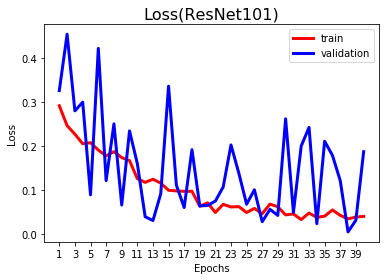

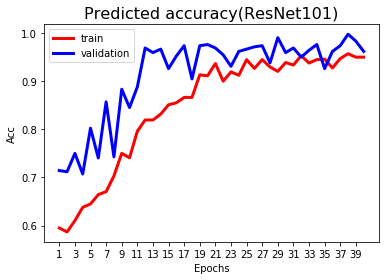

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(ResNet101)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(ResNet101)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

torch.Size([4, 3, 224, 224])


GroundTruth:     77    79    77    81
Predicted:     81    79    77    81


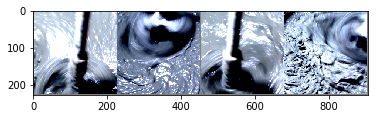

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [16]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  105	0	0	0	

Actual 77  0	104	0	1	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

